# Training a ML model using CICIoT2023

This notebook shows how a LogisticRegression model can be trained using the CICIoT2023 csv files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import keras
# !pip install tensorflow==2.15

print(f"Keras version: {keras.__version__}")


print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for device in tf.config.list_physical_devices('GPU'):
    print(device)


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug  8 11:30:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   40C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

In [ ]:
# unzip the files - /content/drive/MyDrive/IDS-Research/CICIoT2023/CICIoT2023.zip
# !unzip /content/drive/MyDrive/IDS-Research/CICIoT2023/CICIoT2023.zip -d /content/drive/MyDrive/IDS-Research/CICIoT2023

# !mv /content/drive/MyDrive/IDS-Research/CICIoT2023/part* /content/drive/MyDrive/IDS-Research/CICIoT2023/CICIoT2023/

In [ ]:
# DATASET_DIRECTORY = '../CICIoT2023/'   #/content/drive/MyDrive/IDS-Research/CICIoT2023

In [ ]:
DATASET_DIRECTORY = '/content/drive/MyDrive/IDS-Research/CICIoT2023/CICIoT2023/'


### Importing Dataset

In [ ]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
# Use the remaining 20% of files for testing and training
training_sets = df_sets[:int(len(df_sets)*.8)]
test_sets = df_sets[int(len(df_sets)*.8):]

In [ ]:
## check shapes of trainng and test sets
print(len(training_sets))
print(len(test_sets))
del df_sets

135
34


### Scaling

### Classification - Selected class

In [ ]:
### create dictionary for mapping classes
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Data directory
DATASET_DIRECTORY = '/content/drive/MyDrive/IDS-Research/CICIoT2023/CICIoT2023/'

# Columns and labels
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count',
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight',
]
y_column = 'label'

# Class mapping dictionary
dict_7classes = {
    'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS',
    'DoS-UDP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon', 'Recon-HostDiscovery': 'Recon',
    'DNS_Spoofing': 'Spoofing', 'MITM-ArpSpoofing': 'Spoofing',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Web', 'Backdoor_Malware': 'Web', 'XSS': 'Web',
    'Uploading_Attack': 'Web', 'SqlInjection': 'Web', 'CommandInjection': 'Web',
    'DictionaryBruteForce': 'BruteForce'
}





In [ ]:

selected_classes = list(dict_7classes.values())  # Include all classes  # SelectED Classes

# Load and preprocess data
X = pd.DataFrame()
y = pd.Series(dtype=str)

for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    X = pd.concat([X, d[X_columns]], ignore_index=True)
    y = pd.concat([y, d[y_column]], ignore_index=True)
    del d

# Map labels to classes
y_mapped = y.map(dict_7classes)
X = X[y_mapped.isin(selected_classes)]
y_mapped = y_mapped[y_mapped.isin(selected_classes)]
print(" Mapped classes to y ", y_mapped.value_counts())


# Display original class statistics
print("Original Class Statistics:")
print(y_mapped.value_counts())
# # Plot class distribution
# plt.figure(figsize=(10, 6))
# sns.countplot(y=y_mapped, palette='Set2')
# plt.title('Original Class Distribution')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.show()

100%|██████████| 135/135 [11:19<00:00,  5.03s/it]


 Mapped classes to y  DDoS          26458409
DoS            6298571
Mirai          2050447
Benign          854873
Spoofing        378706
Recon           275935
Web              19396
BruteForce       10081
Name: count, dtype: int64
Original Class Statistics:
DDoS          26458409
DoS            6298571
Mirai          2050447
Benign          854873
Spoofing        378706
Recon           275935
Web              19396
BruteForce       10081
Name: count, dtype: int64


In [ ]:
# # Combine the features and labels into a single DataFrame
# import pandas as pd
# import os
# from tqdm import tqdm
# from sklearn.utils import resample
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split
# data = pd.DataFrame(X)
# data['label'] = y_mapped

# # Define target sizes for the larger classes
# target_sizes = {
#     'DDoS': 700000,
#     'DoS': 500000,
#     'Mirai': 400000
# }

# # Function to reduce class size
# def reduce_class_size(data, target_size, class_label):
#     class_data = data[data['label'] == class_label]
#     if len(class_data) > target_size:
#         class_data = resample(class_data, replace=False, n_samples=target_size, random_state=42)
#     return class_data

# # Reduce each class size
# reduced_data = pd.DataFrame()
# for class_label in selected_classes:
#     if class_label in target_sizes:
#         reduced_data = pd.concat([reduced_data, reduce_class_size(data, target_sizes[class_label], class_label)], ignore_index=True)
#     else:
#         reduced_data = pd.concat([reduced_data, data[data['label'] == class_label]], ignore_index=True)

# # Separate the features and labels again
# X_reduced = reduced_data.drop('label', axis=1).values
# y_reduced = reduced_data['label'].values

# # New class distribution
# print("New class distribution after reduction:", pd.Series(y_reduced).value_counts())

# # Feature scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_reduced)
# del X_reduced

# # Encode labels
# encoder = LabelEncoder()
# y_encoded = encoder.fit_transform(y_reduced)

# print("Encoded label counts:")
# print(pd.Series(y_encoded).value_counts())

# del y_reduced

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# # New class distribution in training set
# print("New class distribution in training set:", pd.Series(y_train).value_counts())

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Combine the features and labels into a single DataFrame
data = pd.DataFrame(X)
data['label'] = y_mapped

# Define target sizes for the larger classes
target_sizes = {
    'DDoS': 150000,
    'DoS': 150000,
    'Mirai': 150000
}

# Function to reduce class size
def reduce_class_size(data, target_size, class_label):
    class_data = data[data['label'] == class_label]
    if len(class_data) > target_size:
        class_data = resample(class_data, replace=False, n_samples=target_size, random_state=42)
    return class_data

# Reduce each class size
reduced_data_list = []
for class_label in selected_classes:
    if class_label in target_sizes:
        reduced_data_list.append(reduce_class_size(data, target_sizes[class_label], class_label))
    else:
        reduced_data_list.append(data[data['label'] == class_label])

# Combine the reduced data
reduced_data = pd.concat(reduced_data_list, ignore_index=True)

# Separate the features and labels again
X_reduced = reduced_data.drop('label', axis=1).values
y_reduced = reduced_data['label'].values

# New class distribution
print("New class distribution after reduction:", pd.Series(y_reduced).value_counts())

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
del X_reduced

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_reduced)

print("Encoded label counts:")
print(pd.Series(y_encoded).value_counts())

del y_reduced

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# New class distribution in training set
print("New class distribution in training set:", pd.Series(y_train).value_counts())



New class distribution after reduction: DDoS          1800000
Recon         1379675
Benign         854873
Spoofing       757412
DoS            600000
Mirai          450000
Web            116376
BruteForce      10081
Name: count, dtype: int64
Encoded label counts:
2    1800000
5    1379675
0     854873
6     757412
3     600000
4     450000
7     116376
1      10081
Name: count, dtype: int64
New class distribution in training set: 2    1440000
5    1103740
0     683898
6     605929
3     480000
4     360000
7      93101
1       8065
Name: count, dtype: int64


In [ ]:
# Reshape data for GRU (assuming each row is a timestamp)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

37303/37303 [==============================] - 103s 3ms/step
Overall Accuracy: 0.9140
Overall Precision: 0.9149
Overall Recall: 0.9140
Overall F1-score: 0.9114
Overall FPR: 0.9891
Class           Accuracy   Precision  Recall     F1-score   FPR       
Benign          0.8571     0.8375     0.8571     0.8472     0.2231    
BruteForce      0.1811     0.9812     0.1811     0.3057     0.0002    
DDoS            0.9987     0.9994     0.9987     0.9990     0.0019    
DoS             0.9970     0.9968     0.9970     0.9969     0.0013    
Mirai           0.9977     0.9993     0.9977     0.9985     0.0003    
Recon           0.9258     0.8210     0.9258     0.8703     0.5904    
Spoofing        0.7275     0.8845     0.7275     0.7984     0.2789    
Web             0.4094     0.7348     0.4094     0.5258     0.0901    


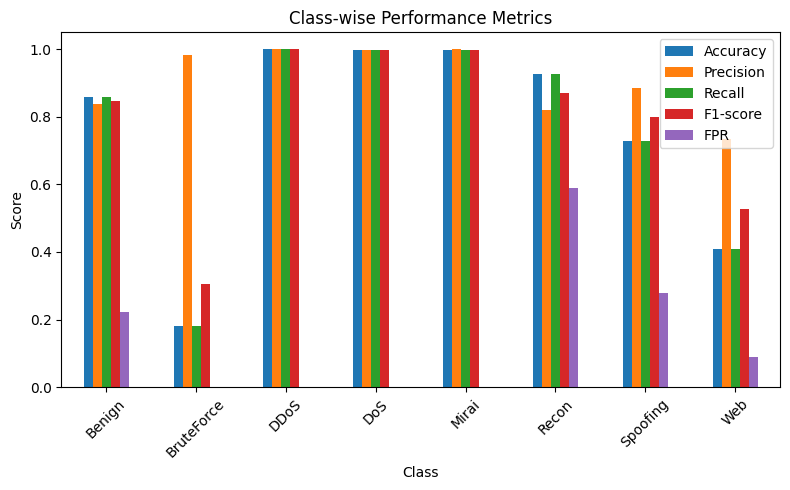

In [ ]:
# ## Aug 06 plots recall , precision , FPR etc
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tensorflow.keras.models import load_model
# from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# import pandas as pd

# # Ensure directory for plots exists
# plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
# if not os.path.exists(plot_directory):
#     os.makedirs(plot_directory)

# # Load the pre-trained model
# checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
# bigru_attention_model = load_model(checkpoint_path)

# # Load the training history
# history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_historyJuly277.npz'
# history = np.load(history_path, allow_pickle=True)
# history = {key: history[key] for key in history}

# # Make predictions
# y_pred_probs = bigru_attention_model.predict(X_test1)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Calculate class-wise metrics
# cm = confusion_matrix(y_test, y_pred, normalize='true')
# accuracy_per_class = cm.diagonal()
# precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
# fpr = {}
# for i in range(len(encoder.classes_)):
#     fpr[i] = (cm[:, i].sum() - cm[i, i]) / cm.sum(axis=0)[i]

# # Print class-wise metrics
# print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'FPR':<10}")
# for i, class_name in enumerate(encoder.classes_):
#     print(f"{class_name:<15} {accuracy_per_class[i]:<10.4f} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f} {fpr[i]:<10.4f}")

# # Plot class-wise metrics
# metrics_data = {
#     'Class': encoder.classes_,
#     'Accuracy': accuracy_per_class,
#     'Precision': precision,
#     'Recall': recall,
#     'F1-score': f1_score,
#     'FPR': [fpr[i] for i in range(len(encoder.classes_))]
# }

# metrics_df = pd.DataFrame(metrics_data)
# metrics_df.plot(kind='bar', x='Class', figsize=(8, 5))
# plt.title('Class-wise Performance Metrics')
# plt.xlabel('Class')
# plt.ylabel('Score')
# plt.xticks(rotation=45)
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_CICIoT2023.svg'), format='svg', dpi=300)
# plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_CICIoT2023.jpeg'), format='jpeg', dpi=300)
# plt.show()
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import pandas as pd

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
bigru_attention_model = load_model(checkpoint_path)

# Load the training history
history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_historyJuly277.npz'
history = np.load(history_path, allow_pickle=True)
history = {key: history[key] for key in history}

# Make predictions
y_pred_probs = bigru_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate overall metrics
overall_accuracy = accuracy_score(y_test, y_pred)
overall_precision, overall_recall, overall_f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
overall_fpr = np.sum(cm[:, :-1]) / np.sum(cm)

# Print overall metrics
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-score: {overall_f1_score:.4f}")
print(f"Overall FPR: {overall_fpr:.4f}")

# Calculate class-wise metrics
cm = confusion_matrix(y_test, y_pred, normalize='true')
accuracy_per_class = cm.diagonal()
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
fpr = {}
for i in range(len(encoder.classes_)):
    fpr[i] = (cm[:, i].sum() - cm[i, i]) / cm.sum(axis=0)[i]

# Print class-wise metrics
print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'FPR':<10}")
for i, class_name in enumerate(encoder.classes_):
    print(f"{class_name:<15} {accuracy_per_class[i]:<10.4f} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f} {fpr[i]:<10.4f}")

# Plot class-wise metrics
metrics_data = {
    'Class': encoder.classes_,
    'Accuracy': accuracy_per_class,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1_score,
    'FPR': [fpr[i] for i in range(len(encoder.classes_))]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.plot(kind='bar', x='Class', figsize=(8, 5))
plt.title('Class-wise Performance Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_CICIoT2023.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_CICIoT2023.jpeg'), format='jpeg', dpi=300)
plt.show()


In [ ]:
###
## load data
import numpy as np
import os
# save_dir ='/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
#save_dir = '/content/drive/MyDrive/IDS-Research/train_test_data_cicddos2019'
# save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
# %cd /content/drive/MyDrive/IDS-Research/
# !ls
# %cd /content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set
import numpy as np
import os

save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'

# Load the datasets using the correct filenames
X_train = np.load(os.path.join(save_dir, 'X_train.npy'))
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
Y_train = np.load(os.path.join(save_dir, 'y_train.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Print the shapes of the loaded datasets
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(37349263, 1, 30)
(9337316, 1, 30)
(37349263,)
(9337316,)


In [ ]:
## plot confusion matrix cicIoT2023 - 08-10
## plot confusion matrix cicIoT2023 - 08-10
# Ensure necessary libraries are imported
## SEPTEMBER
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import pandas as pd

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
bigru_attention_model = load_model(checkpoint_path)

# Load the training history
history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_historyJuly277.npz'
history = np.load(history_path, allow_pickle=True)
history = {key: history[key] for key in history}

# Adjust font sizes globally
plt.rcParams.update({'font.size': 13, 'axes.labelsize': 13, 'legend.fontsize': 13, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

# Make predictions
y_pred_probs = bigru_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# Add title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Save the plot
output_path = os.path.join(plot_directory, 'Confusion_Matrix_CICIoT2023_SP.jpeg')
plt.savefig(output_path, format='jpeg')

# Show the plot
plt.show()


# Arrange X and Y axis labels



ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 1, 46), found shape=(None, 1, 30)


37303/37303 [==============================] - 98s 3ms/step


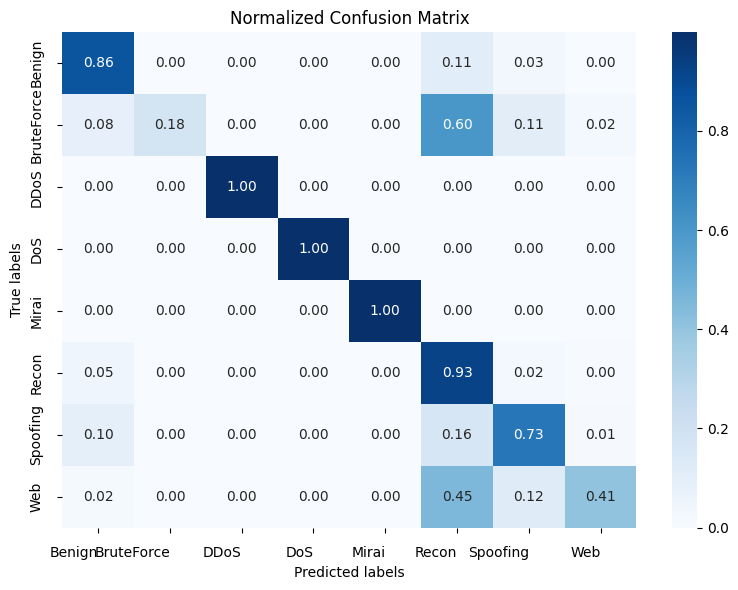

In [ ]:
### Confusion matrix plot Aug 12
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tensorflow.keras.models import load_model
# from sklearn.metrics import confusion_matrix

# # Ensure directory for plots exists
# plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
# if not os.path.exists(plot_directory):
#     os.makedirs(plot_directory)

# # Load the pre-trained model
# checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
# bigru_attention_model = load_model(checkpoint_path)

# # Load the training history
# history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_historyJuly277.npz'
# history = np.load(history_path, allow_pickle=True)
# history = {key: history[key] for key in history}

# # Make predictions
# y_pred_probs = bigru_attention_model.predict(X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Calculate confusion matrix
# cm = confusion_matrix(y_test, y_pred, normalize='true')

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Normalized Confusion Matrix')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')

# # Save the plot as SVG and JPEG
# plt.tight_layout()
# plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix.svg'), format='svg')
# plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix.jpeg'), format='jpeg')
# plt.show()
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tensorflow.keras.models import load_model
# from sklearn.metrics import confusion_matrix

# # Ensure directory for plots exists
# plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
# if not os.path.exists(plot_directory):
#     os.makedirs(plot_directory)

# # Load the pre-trained model
# checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
# bigru_attention_model = load_model(checkpoint_path)

# # Load the training history
# history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_historyJuly277.npz'
# history = np.load(history_path, allow_pickle=True)
# history = {key: history[key] for key in history}

# # Make predictions
# y_pred_probs = bigru_attention_model.predict(X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Calculate confusion matrix
# cm = confusion_matrix(y_test, y_pred, normalize='true')

# # Plot confusion matrix with changed text orientation
# plt.figure(figsize=(8, 6))
# ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# # Rotate x-axis labels
# plt.xticks(rotation=0, ha='right')  # Adjust rotation angle and alignment as needed

# # Rotate y-axis labels
# plt.yticks(rotation=90)  # Adjust rotation angle as needed

# plt.title('Normalized Confusion Matrix')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')

# # Save the plot as SVG and JPEG
# plt.tight_layout()
# plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix_Labels_Orientation.svg'), format='svg')
# plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix_Labels_Orientation.jpeg'), format='jpeg')
# plt.show()

## SEPTEMBER
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
bigru_attention_model = load_model(checkpoint_path)

# Load the training history
history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_historyJuly277.npz'
history = np.load(history_path, allow_pickle=True)
history = {key: history[key] for key in history}

# Make predictions
y_pred_probs = bigru_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
# Adjust font sizes
plt.rcParams.update({'font.size': 13, 'axes.labelsize': 13, 'legend.fontsize': 13, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# Rotate x-axis labels (kept unchanged)
plt.xticks(rotation=0, ha='right', fontsize=10)

# Rotate y-axis labels (kept unchanged)
plt.yticks(rotation=90, fontsize=10)

# Adjust label spacing for clarity by modifying tick positions
ax.tick_params(axis='x', pad=10)  # Increase space between x-axis labels and plot
ax.tick_params(axis='y', pad=10)  # Increase space between y-axis labels and plot

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Save the plot as SVG and JPEG
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix_Labels_Orientation.svg'), format='svg')
plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix_Labels_Orientation.jpeg'), format='jpeg')
plt.show()





37303/37303 [==============================] - 99s 3ms/step


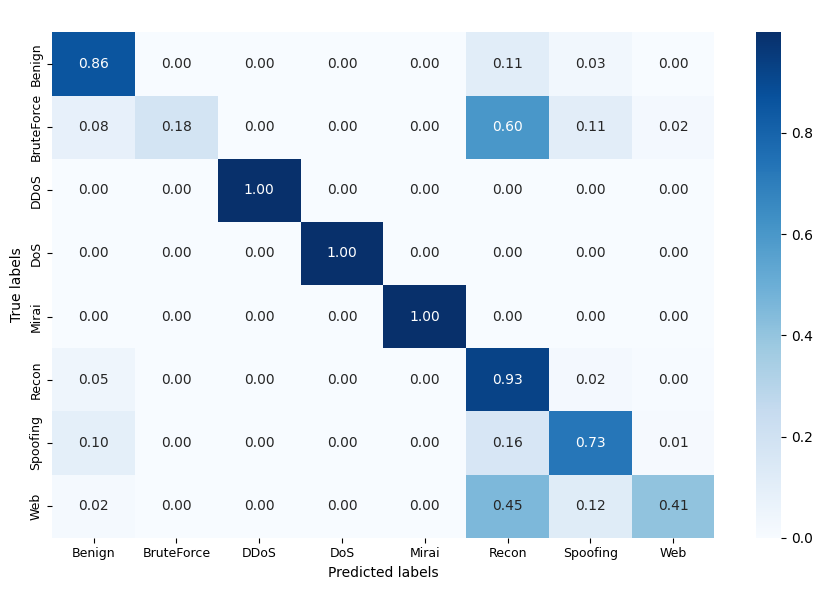

In [ ]:
# 8-12 conf mat
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
bigru_attention_model = load_model(checkpoint_path)

# Load the training history
history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_historyJuly277.npz'
history = np.load(history_path, allow_pickle=True)
history = {key: history[key] for key in history}

# Make predictions
y_pred_probs = bigru_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Adjust font sizes
plt.rcParams.update({'font.size': 13, 'axes.labelsize': 13, 'legend.fontsize': 13, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

# Plot confusion matrix
plt.figure(figsize=(9, 6))
ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# Rotate x-axis labels (kept unchanged)
plt.xticks(rotation=0, ha='right', fontsize=9)

# Rotate y-axis labels (kept unchanged)
plt.yticks(rotation=90, fontsize=9)

# Manually adjust label positions for better visibility
# Example adjustment: adding padding to specific labels
for tick in ax.get_xticklabels():
    tick.set_horizontalalignment('center')  # Adjust alignment
    tick.set_x(tick.get_position()[0] + 0.1)  # Example adjustment: move label to the right

for tick in ax.get_yticklabels():
    tick.set_verticalalignment('center')  # Adjust alignment
    tick.set_y(tick.get_position()[1] + 0.1)  # Example adjustment: move label up

plt.title('  ')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Save the plot as SVG and JPEG
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix_Labels_Adjusted.svg'), format='svg')
plt.savefig(os.path.join(plot_directory, 'CICIot2023_Confusion_Matrix_Labels_Adjusted.jpeg'), format='jpeg')
plt.show()


In [ ]:
import tensorflow as tf

!pip install tensorflow==2.15.0


print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installatio

2.17.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14800793897660525953
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21991653376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 809769383940202681
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]


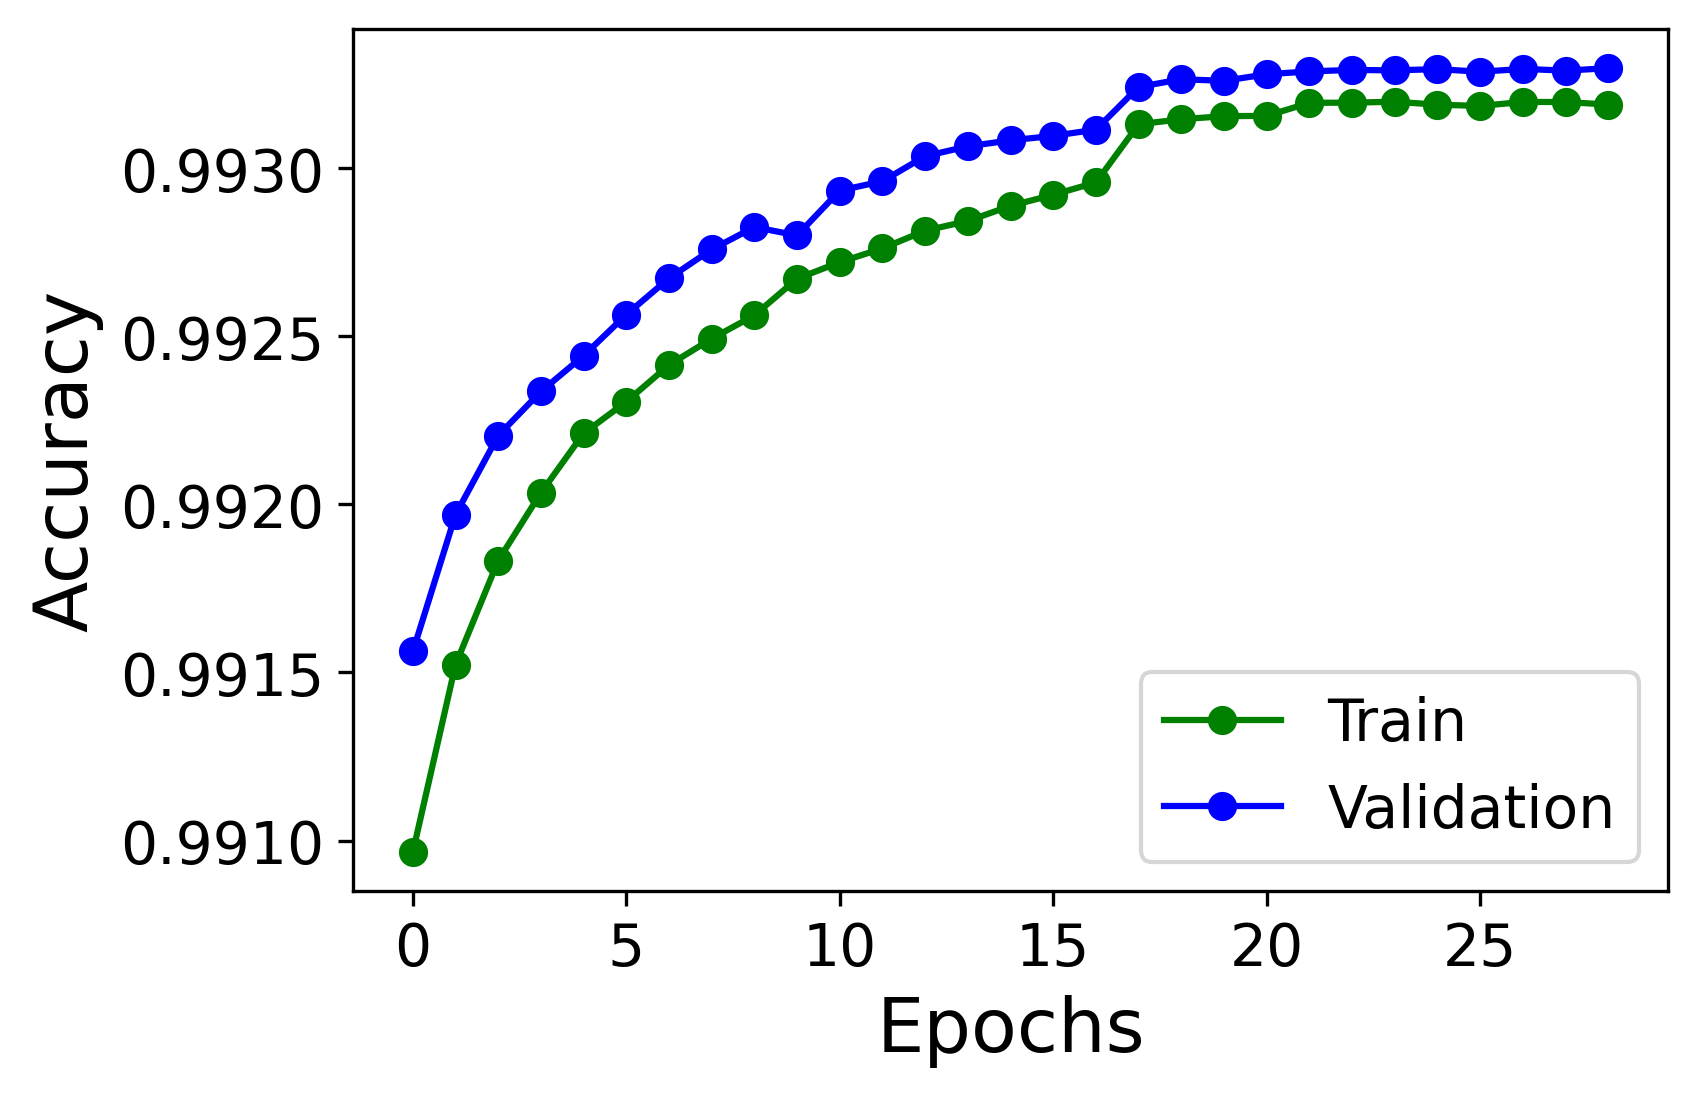

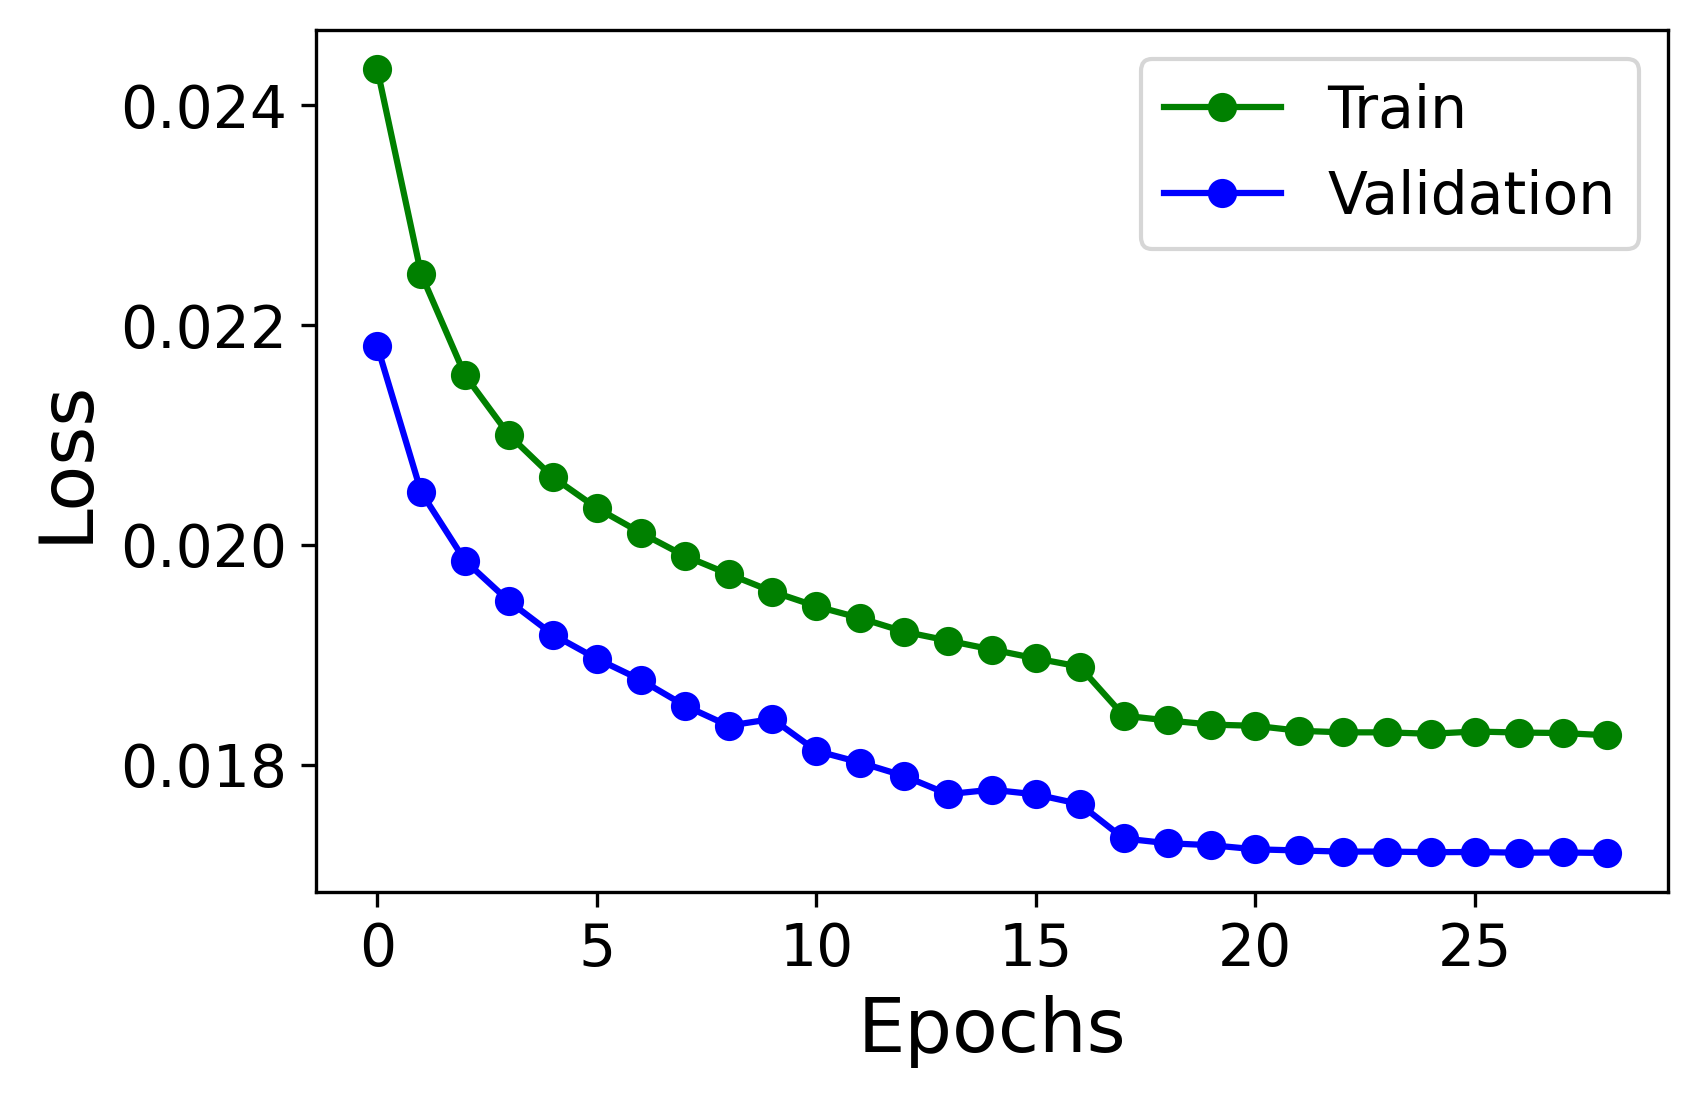

291792/291792 [==============================] - 761s 3ms/step
Classification Report:
              precision    recall  f1-score   support

        DDoS       0.86      0.95      0.91    219344
  BruteForce       0.94      0.18      0.30      2615
       Mirai       1.00      1.00      1.00   6795431
      Benign       1.00      1.00      1.00   1618443
    Spoofing       1.00      1.00      1.00    528107
       Recon       0.81      0.72      0.76     70873
         Dos       0.83      0.76      0.79     97511
         Web       0.78      0.14      0.24      4992

    accuracy                           0.99   9337316
   macro avg       0.90      0.72      0.75   9337316
weighted avg       0.99      0.99      0.99   9337316

Overall Accuracy: 0.9933
Overall Precision: 0.9020
Overall Recall: 0.7183
Overall F1-score: 0.7496
Overall FPR: 0.0980
DDoS: Accuracy=0.9954, Precision=0.8643, Recall=0.9521, F1-score=0.9061, FPR=0.1357
BruteForce: Accuracy=0.9998, Precision=0.9430, Recall=0.1771

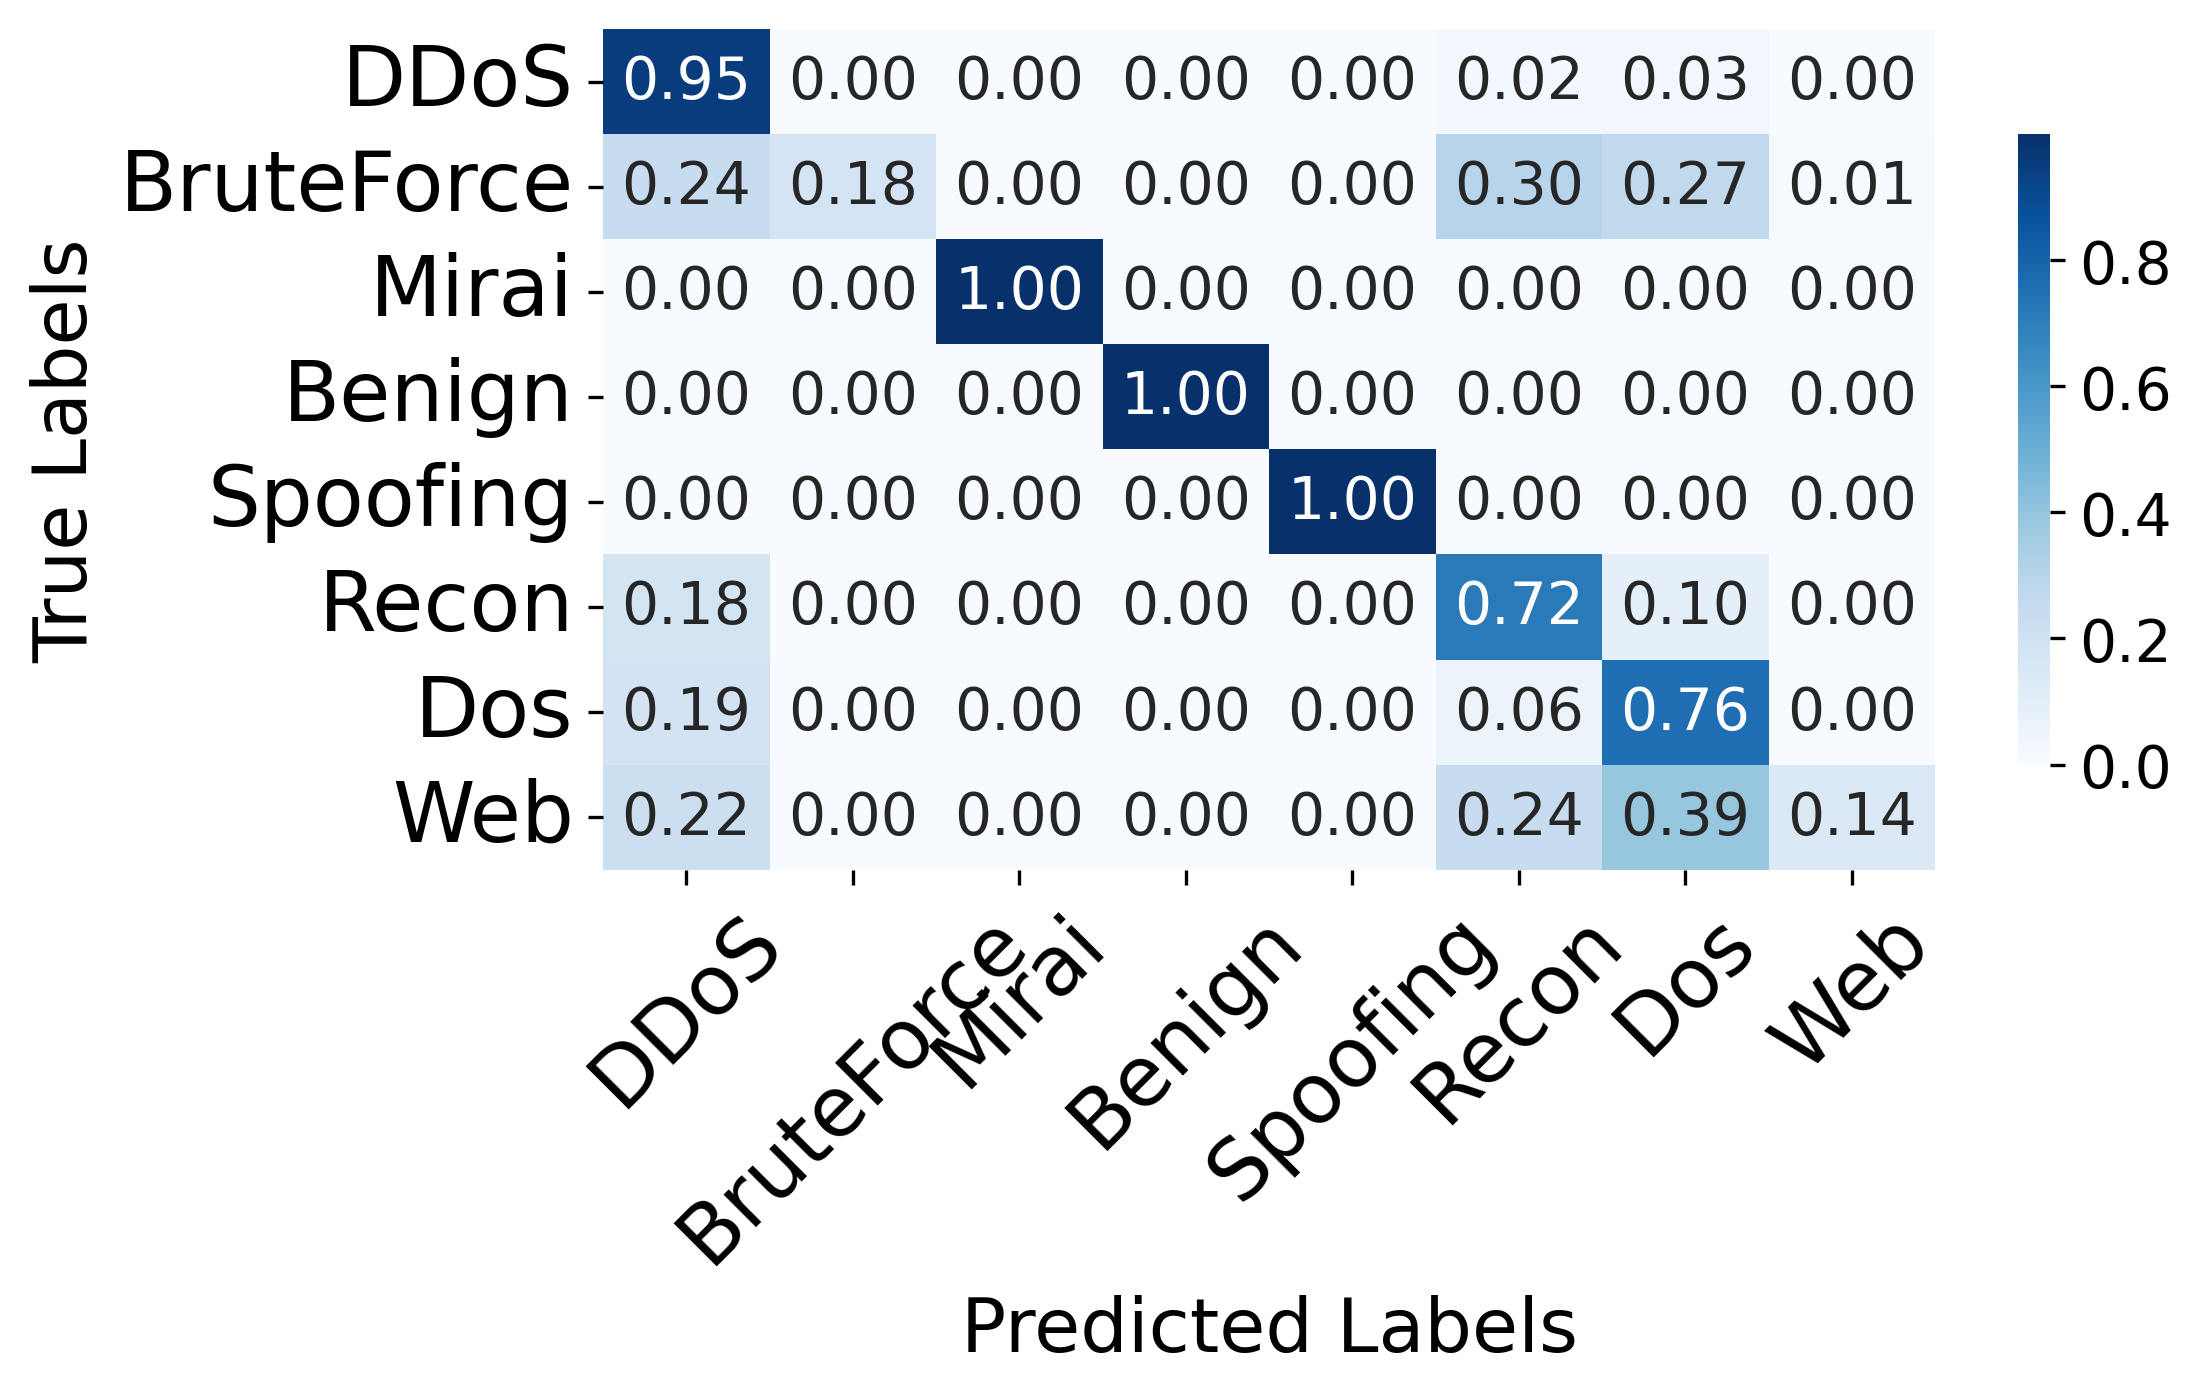

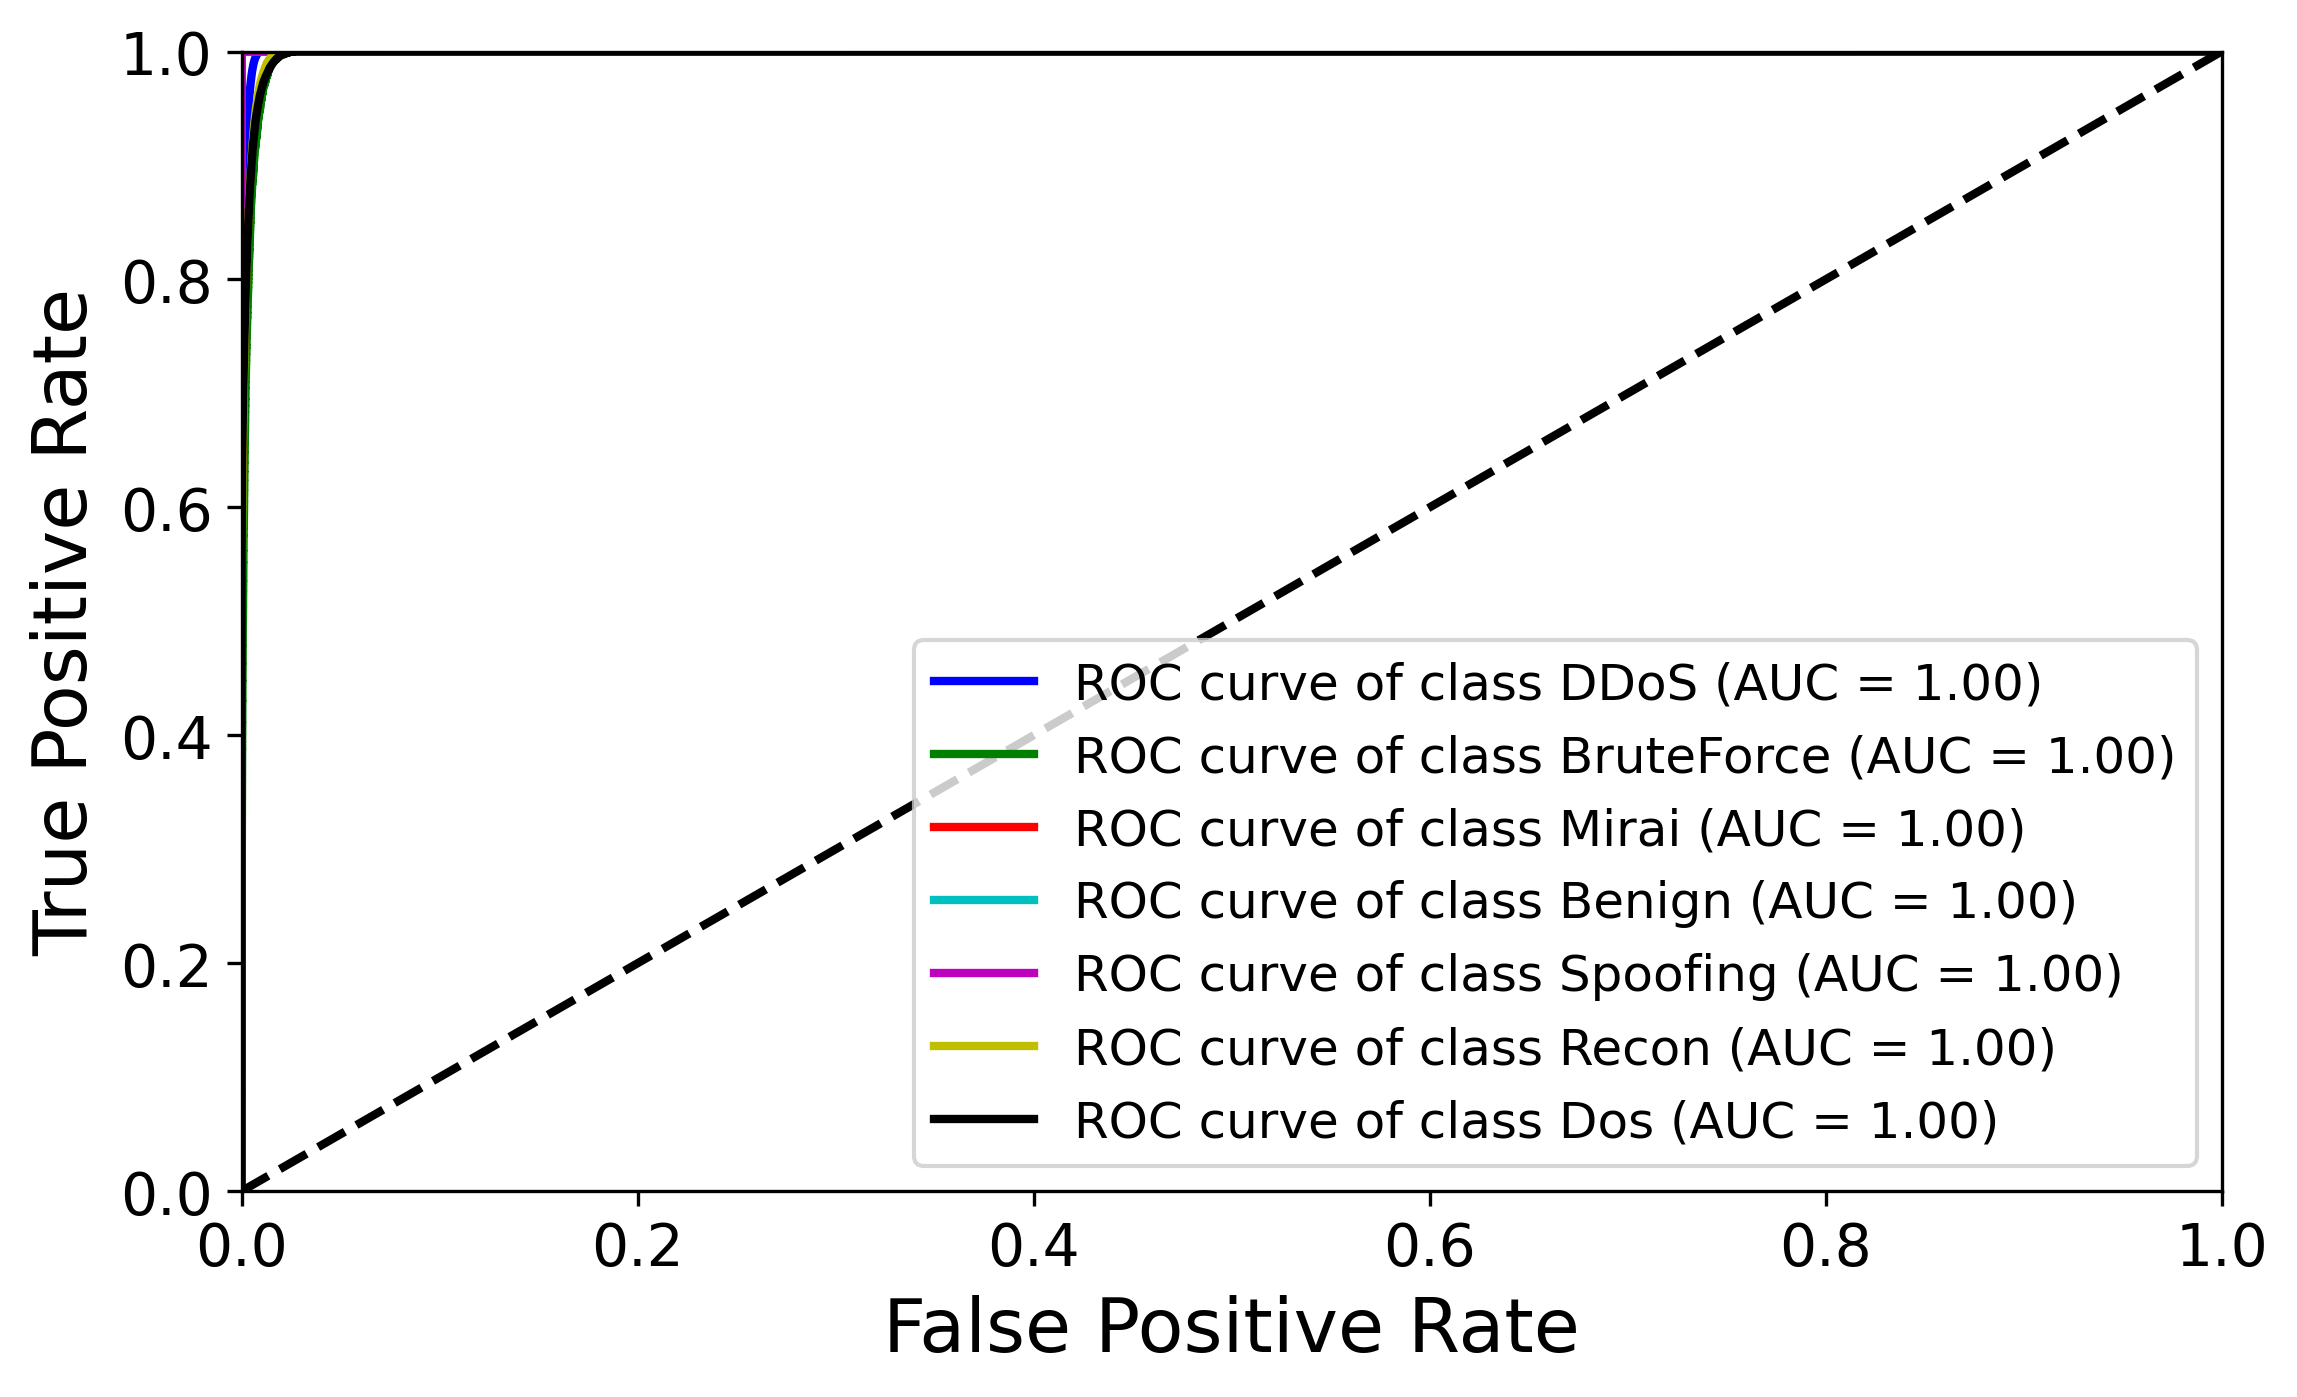

In [ ]:
  ## November
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
  from tensorflow.keras.models import load_model
  import os
  from matplotlib.ticker import FormatStrFormatter
  from sklearn.preprocessing import LabelEncoder

  # Define paths
  model_checkpoint_filepath = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'
  save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'

  # Load the datasets
  X_train = np.load(os.path.join(save_dir, 'X_train.npy'))
  X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
  Y_train = np.load(os.path.join(save_dir, 'y_train.npy'))
  Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

  # Create the save directory if it doesn't exist
  os.makedirs(save_dir, exist_ok=True)

  # Load the model
  loaded_model = load_model(model_checkpoint_filepath)

  # Adjust font sizes globally
  plt.rcParams.update({'font.size': 18, 'axes.labelsize': 18, 'legend.fontsize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14})

  # Load training history
  history_filepath = '/content/drive/MyDrive/IDS-Research/CICIoT2023_0814_history.npz'
  history = np.load(history_filepath)
  accuracy = history['accuracy'][1:]
  val_accuracy = history['val_accuracy'][1:]
  loss = history['loss'][1:]
  val_loss = history['val_loss'][1:]

  # Plot training & validation accuracy
  plt.figure(figsize=(6.0, 4.0), dpi=300)
  plt.plot(accuracy, color="green", marker='o', label='Train')
  plt.plot(val_accuracy, color="blue", marker='o', label='Validation')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.xticks(np.arange(0, len(accuracy), step=5))
  plt.legend(loc='lower right')
  plt.tight_layout()
  plt.savefig(os.path.join(save_dir, 'Accuracy_CICIoT2023_0814_SP_1105.jpeg'), format='jpeg', dpi=300, bbox_inches='tight')
  plt.show()

  # Plot training & validation loss
  plt.figure(figsize=(6.0, 4.0), dpi=300)
  plt.plot(loss, color="green", marker='o', label='Train')
  plt.plot(val_loss, color="blue", marker='o', label='Validation')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.xticks(np.arange(0, len(loss), step=5))
  plt.legend(loc='upper right')
  plt.tight_layout()
  plt.savefig(os.path.join(save_dir, 'Loss_CICIoT2023_0814_SP_1105.jpeg'), format='jpeg', dpi=300, bbox_inches='tight')
  plt.show()

  # Load test data and make predictions
  y_test = Y_test
  y_pred_probs = loaded_model.predict(X_test)
  y_pred = np.argmax(y_pred_probs, axis=1)

  # Classification report
  encoder = LabelEncoder()
  encoder.classes_ = np.array(['DDoS', 'BruteForce', 'Mirai', 'Benign', 'Spoofing', 'Recon', 'Dos', 'Web'])
  class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
  print("Classification Report:")
  print(class_report)

  # Compute overall performance metrics
  overall_accuracy = accuracy_score(y_test, y_pred)
  overall_precision = precision_score(y_test, y_pred, average='macro')
  overall_recall = recall_score(y_test, y_pred, average='macro')
  overall_f1 = f1_score(y_test, y_pred, average='macro')
  overall_fpr = 1 - overall_precision

  print(f"Overall Accuracy: {overall_accuracy:.4f}")
  print(f"Overall Precision: {overall_precision:.4f}")
  print(f"Overall Recall: {overall_recall:.4f}")
  print(f"Overall F1-score: {overall_f1:.4f}")
  print(f"Overall FPR: {overall_fpr:.4f}")

  # Compute and display class-wise metrics
  for i, class_name in enumerate(encoder.classes_):
      class_accuracy = accuracy_score(y_test == i, y_pred == i)
      class_precision = precision_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
      class_recall = recall_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
      class_f1 = f1_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
      class_fpr = 1 - class_precision

      print(f"{class_name}: Accuracy={class_accuracy:.4f}, Precision={class_precision:.4f}, Recall={class_recall:.4f}, F1-score={class_f1:.4f}, FPR={class_fpr:.4f}")

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred, normalize='true')
  plt.figure(figsize=(8, 5), dpi=300)
  sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
              xticklabels=encoder.classes_, yticklabels=encoder.classes_,
              cbar_kws={'shrink': 0.75,'ticks':np.arange(0.0, 1.1, 0.2)}, annot_kws={"size": 14},vmin=0.0, vmax=1.0)
  plt.xticks(fontsize=20,rotation=45)
  plt.yticks(fontsize=20  ,rotation=0)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.tight_layout()
  plt.savefig(os.path.join(save_dir, 'Confusion_Matrix_CICIoT2023_0814_SP_1107.jpeg'), dpi=300, format='jpeg', bbox_inches='tight')
  plt.show()

  # ROC curves for each class
  plt.figure(figsize=(8, 5), dpi=300)
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
  fpr, tpr, roc_auc = {}, {}, {}
  for i, color in zip(range(len(encoder.classes_)), colors):
      fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (AUC = {1:0.2f})'.format(encoder.classes_[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.xticks(np.arange(0.0, 1.1, step=0.2), fontsize=20)  # Set x-ticks
  plt.yticks(np.arange(0.0, 1.1, step=0.2), fontsize=20)  # Set y-ticks
  plt.legend(loc="lower right", fontsize=12)
  plt.tight_layout()
  plt.savefig(os.path.join(save_dir, 'ROC_Curve_CICIoT2023_0814_SP_1107.jpeg'), dpi=300, bbox_inches='tight')
  plt.show()


In [ ]:
!import tensorflow as tf

!pip install tensorflow==2.15.0


print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

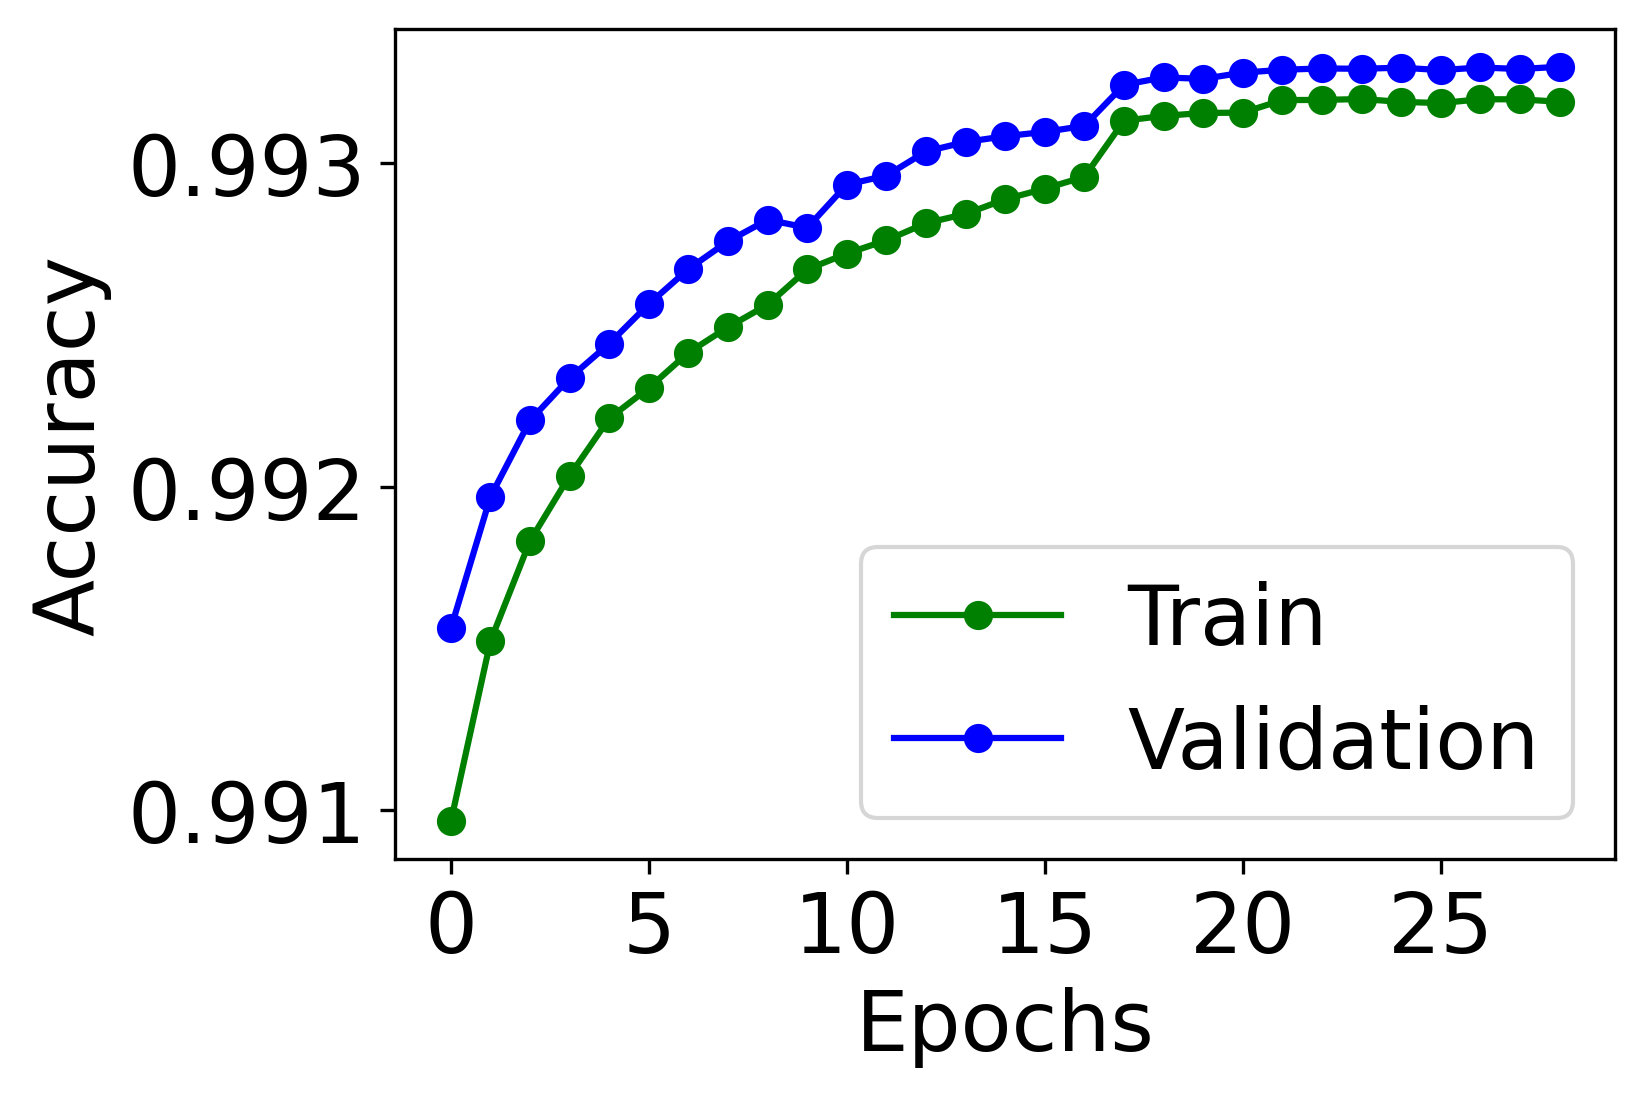

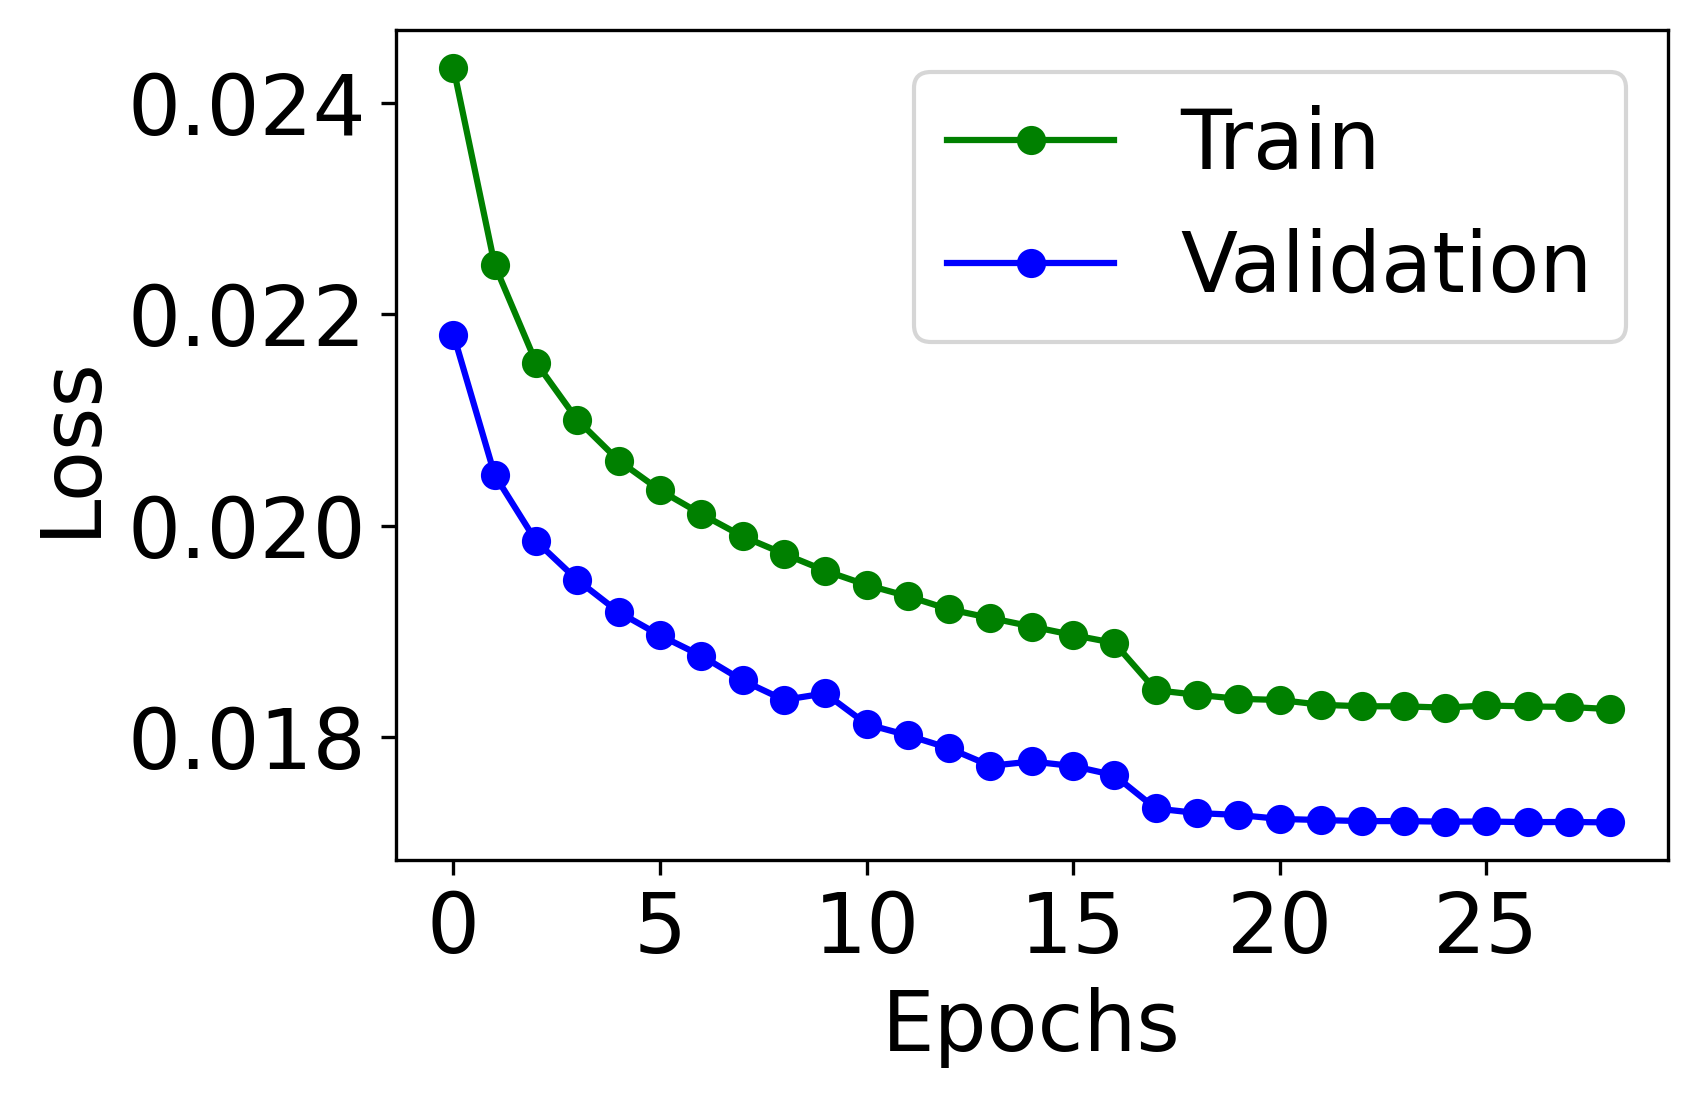

291792/291792 [==============================] - 785s 3ms/step
Classification Report:
              precision    recall  f1-score   support

        DDoS       0.86      0.95      0.91    219344
  BruteForce       0.94      0.18      0.30      2615
       Mirai       1.00      1.00      1.00   6795431
      Benign       1.00      1.00      1.00   1618443
    Spoofing       1.00      1.00      1.00    528107
       Recon       0.81      0.72      0.76     70873
         Dos       0.83      0.76      0.79     97511
         Web       0.78      0.14      0.24      4992

    accuracy                           0.99   9337316
   macro avg       0.90      0.72      0.75   9337316
weighted avg       0.99      0.99      0.99   9337316

Overall Accuracy: 0.9933
Overall Precision: 0.9020
Overall Recall: 0.7183
Overall F1-score: 0.7496
Overall FPR: 0.0980
DDoS: Accuracy=0.9954, Precision=0.8643, Recall=0.9521, F1-score=0.9061, FPR=0.1357
BruteForce: Accuracy=0.9998, Precision=0.9430, Recall=0.1771

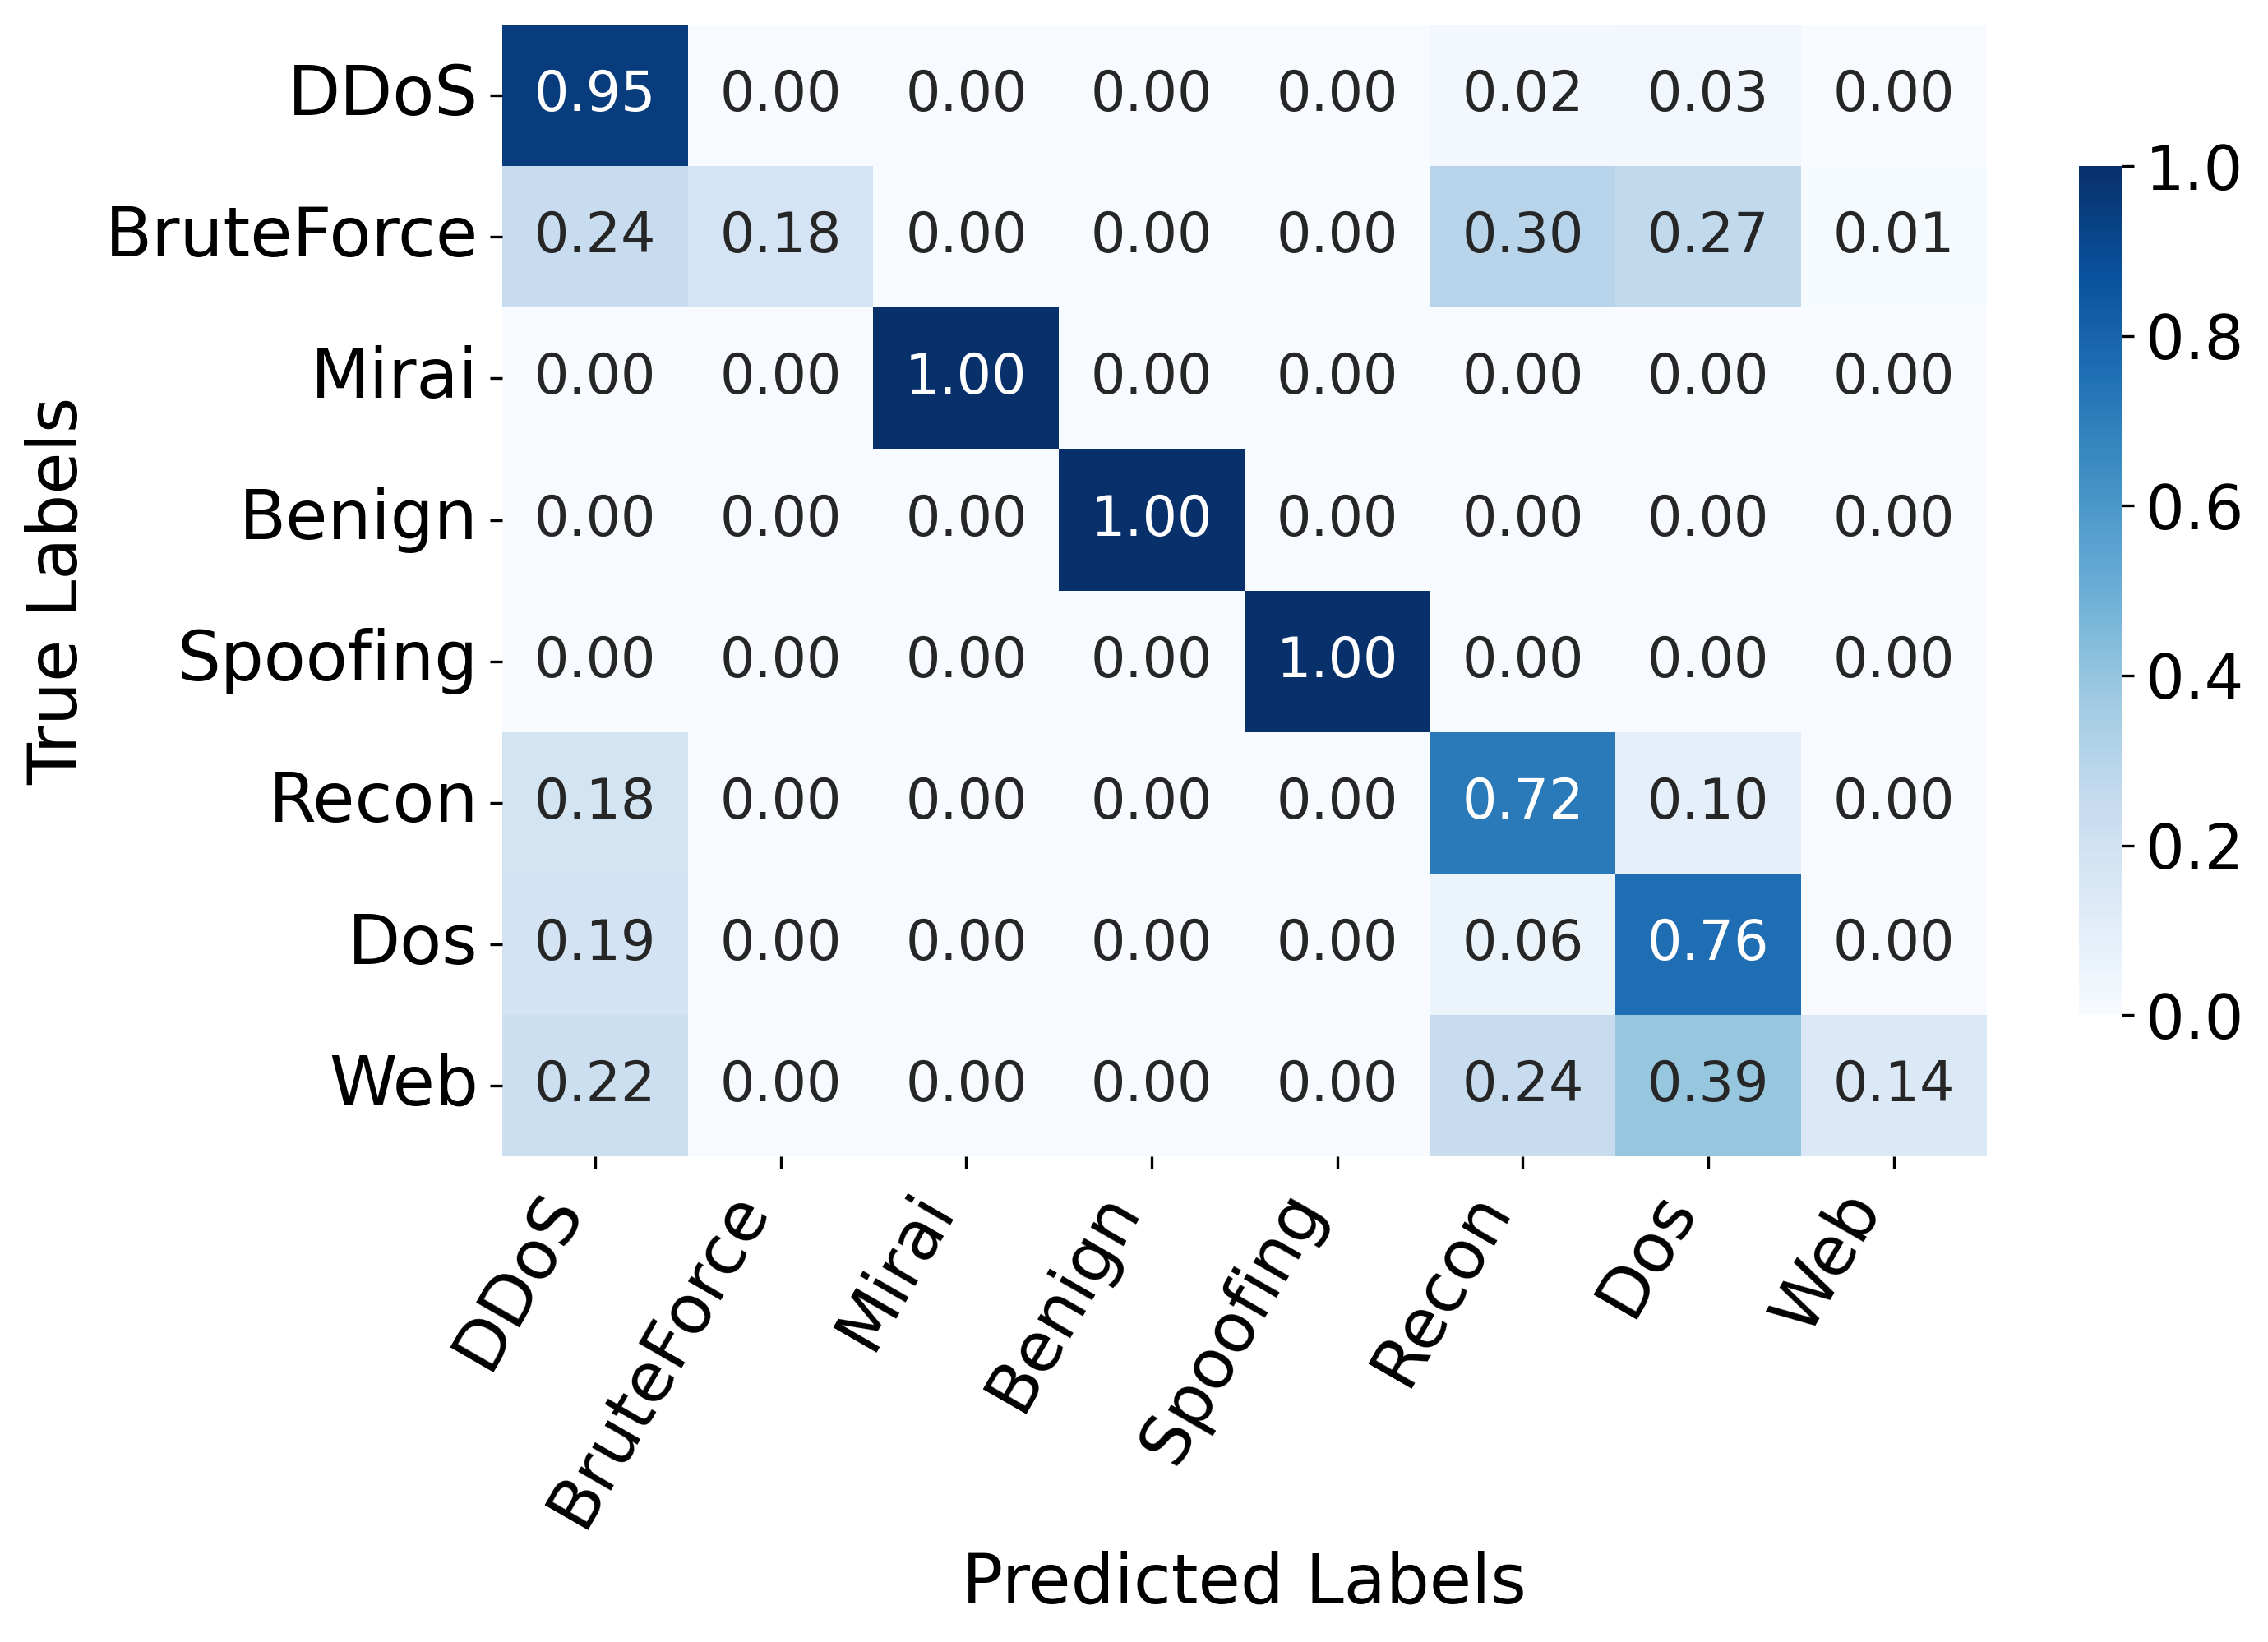

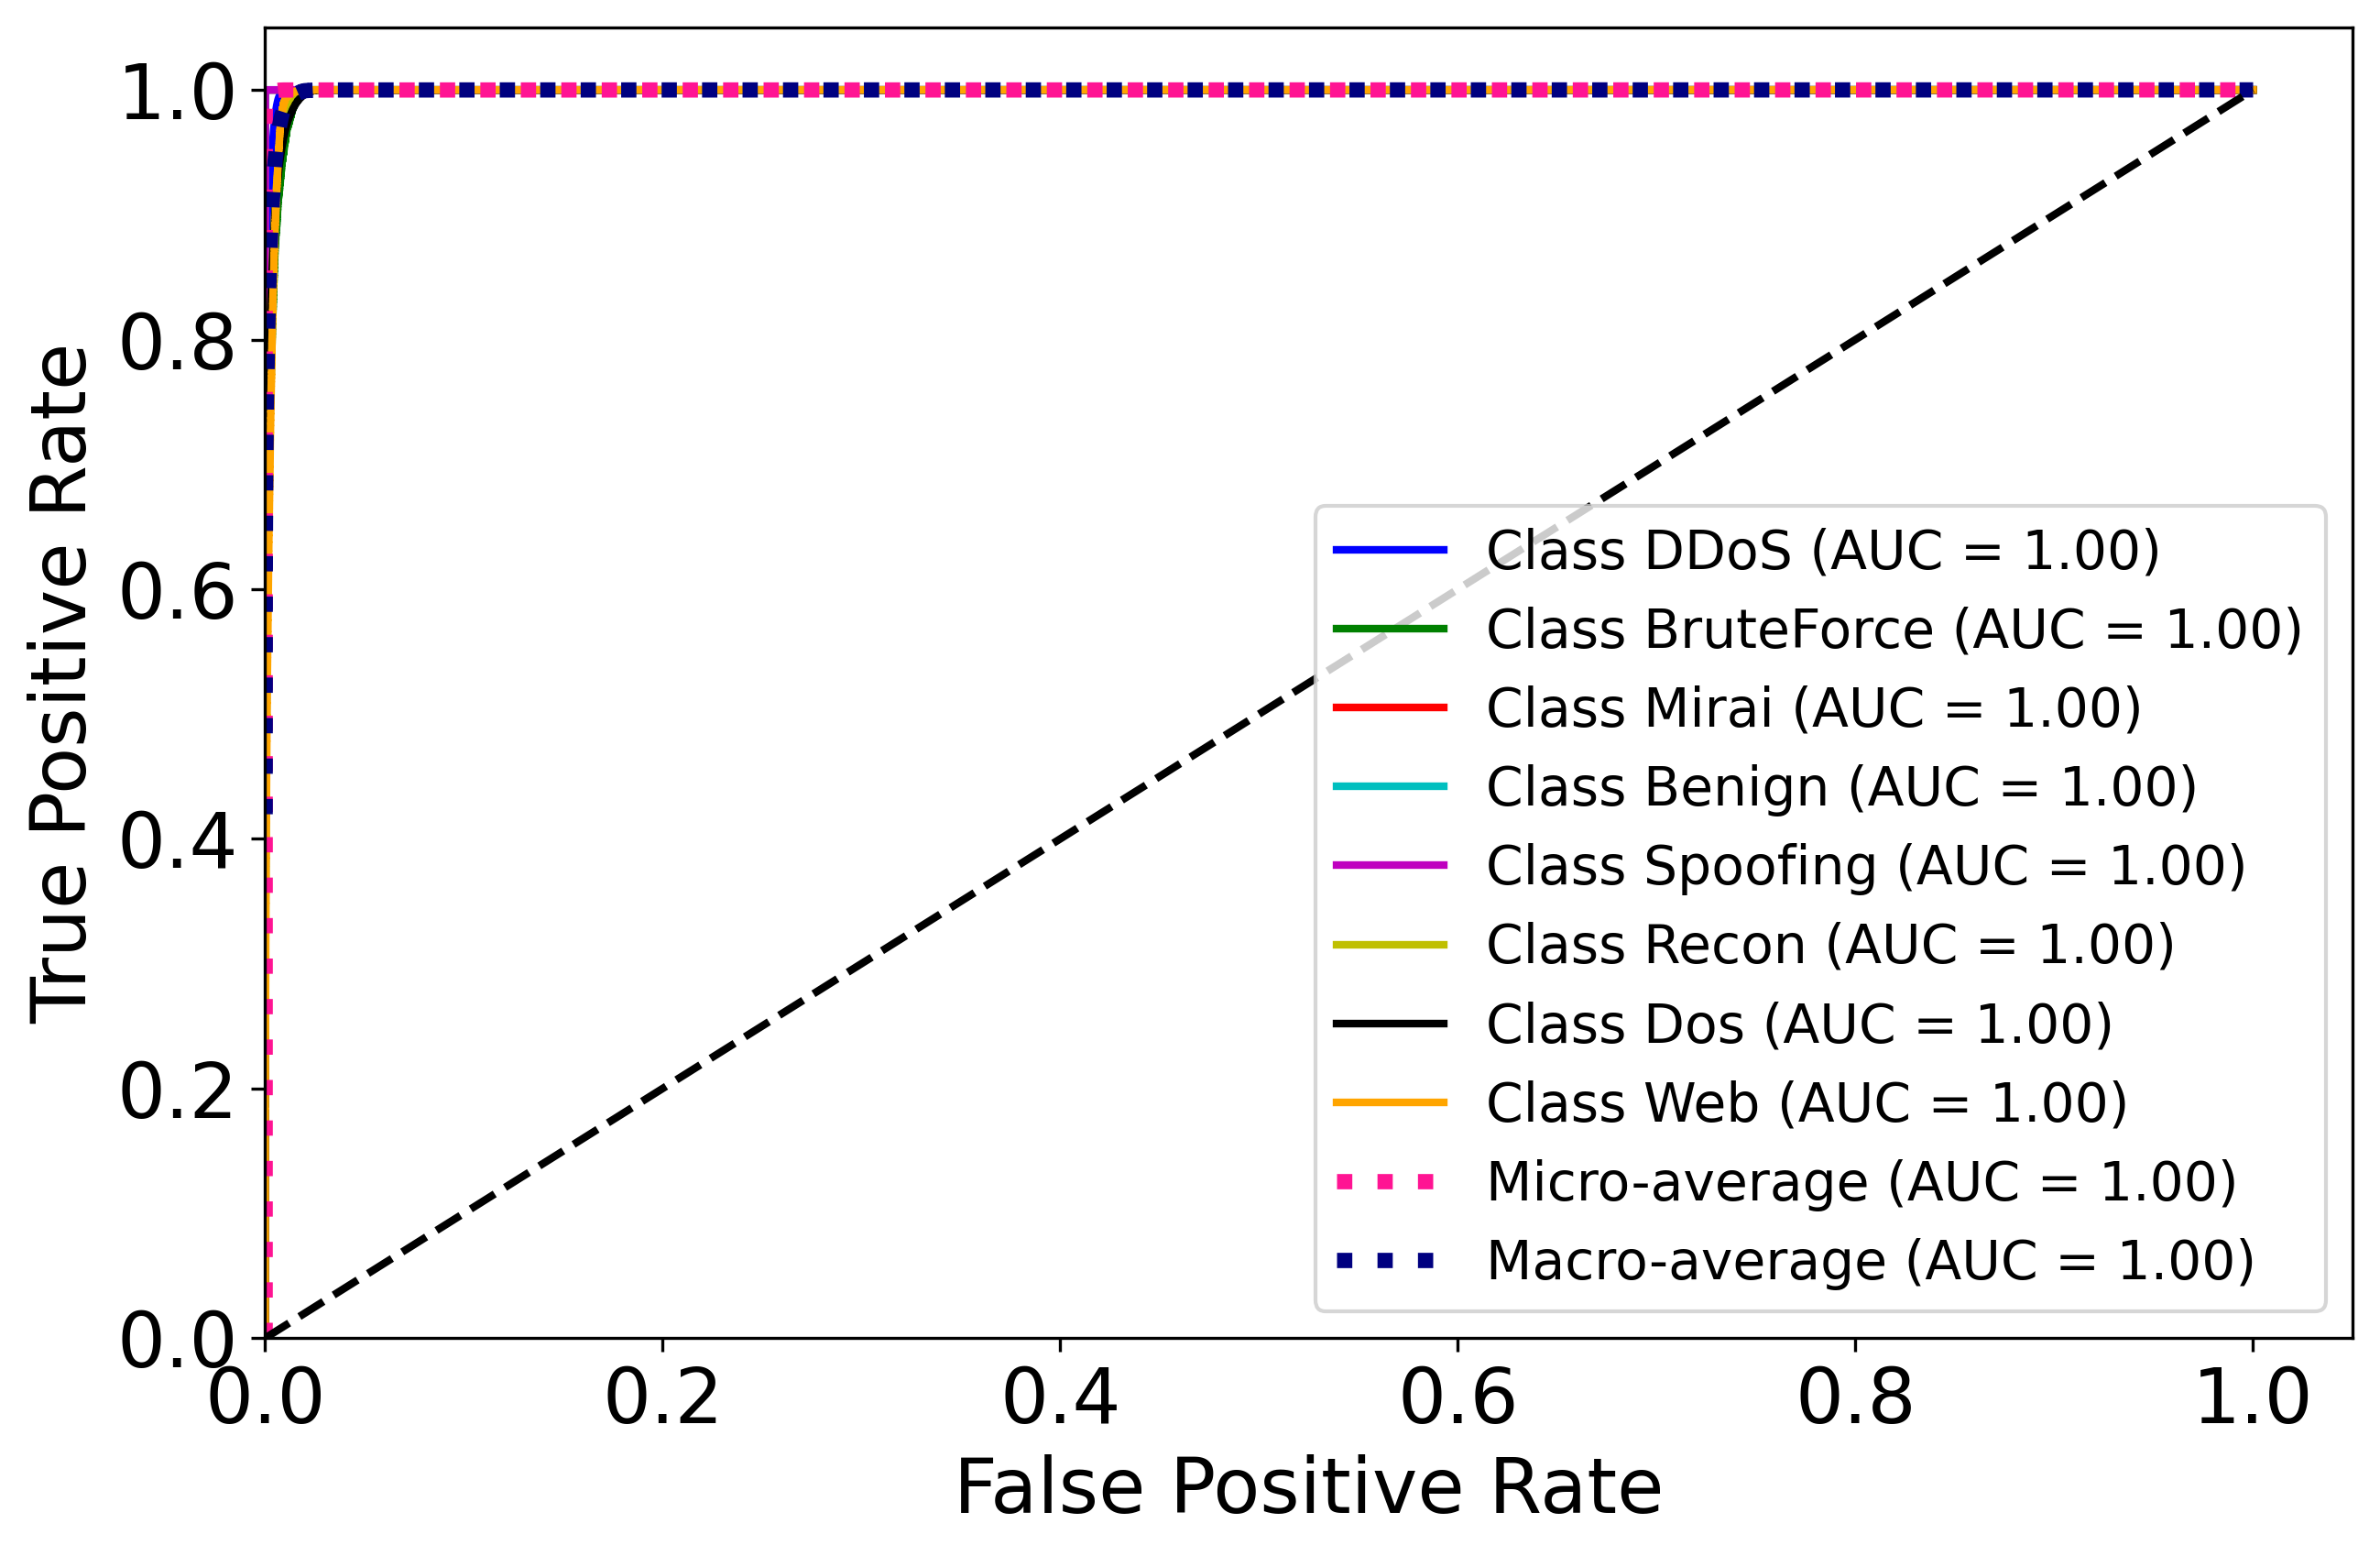

In [ ]:
### November 07...
### November plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import os
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define paths
model_checkpoint_filepath = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'

# Load the datasets using the correct filenames
X_train = np.load(os.path.join(save_dir, 'X_train.npy'))
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
Y_train = np.load(os.path.join(save_dir, 'y_train.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Create the save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Reload the model
loaded_model = load_model(model_checkpoint_filepath)

# Adjust font sizes
plt.rcParams.update({'font.size': 18, 'axes.labelsize': 18, 'legend.fontsize': 18, 'xtick.labelsize': 18, 'ytick.labelsize': 18})

# Reload the history
history_filepath = '/content/drive/MyDrive/IDS-Research/CICIoT2023_0814_history.npz'
history = np.load(history_filepath)
accuracy = history['accuracy'][1:]
val_accuracy = history['val_accuracy'][1:]
loss = history['loss'][1:]
val_loss = history['val_loss'][1:]

# Plot training & validation accuracy
plt.figure(figsize=(6.0, 4.0), dpi=300)
plt.plot(accuracy, color="green", marker='o', label='Train')
plt.plot(val_accuracy, color="blue", marker='o', label='Validation')
plt.title('', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.xticks(np.arange(0, len(accuracy), step=5), fontsize=20)  # Set x-ticks to step value of 5
plt.yticks(fontsize=20)
plt.legend(loc='lower right', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Accuracy_CICIoT2023_0814_SP_1106.jpeg'), format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

# Plot training & validation loss
plt.figure(figsize=(6.0, 4.0), dpi=300)
plt.plot(loss, color="green", marker='o', label='Train')
plt.plot(val_loss, color="blue", marker='o', label='Validation')
plt.title('', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.xticks(np.arange(0, len(loss), step=5), fontsize=20)  # Set x-ticks to step value of 5
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Loss_CICIoT2023_0814_SP_1106.jpeg'), format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

# Load test data and make predictions
X_test = X_test
y_test = Y_test
y_pred_probs = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
encoder = LabelEncoder()
encoder.classes_ = np.array(['DDoS', 'BruteForce', 'Mirai', 'Benign', 'Spoofing', 'Recon', 'Dos', 'Web'])
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Compute overall performance metrics with macro average
overall_accuracy = accuracy_score(y_test, y_pred)
overall_precision = precision_score(y_test, y_pred, average='macro')
overall_recall = recall_score(y_test, y_pred, average='macro')
overall_f1 = f1_score(y_test, y_pred, average='macro')
overall_fpr = 1 - overall_precision  # For overall FPR, calculated as 1 - precision

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-score: {overall_f1:.4f}")
print(f"Overall FPR: {overall_fpr:.4f}")

# Compute and display class-wise metrics - micro
for i, class_name in enumerate(encoder.classes_):
    class_accuracy = accuracy_score(y_test == i, y_pred == i)
    class_precision = precision_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
    class_recall = recall_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
    class_f1 = f1_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
    class_fpr = 1 - class_precision  # Class-wise FPR

    print(f"{class_name}: Accuracy={class_accuracy:.4f}, Precision={class_precision:.4f}, Recall={class_recall:.4f}, F1-score={class_f1:.4f}, FPR={class_fpr:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10.0, 7.0), dpi=300)  # Adjusted size for clarity
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_,
            cbar_kws={'shrink': 0.75,'ticks': np.arange(0.0, 1.1, 0.2)},annot_kws={"size": 16},vmin=0.0, vmax=1.0)  # Increase line thickness
#np.arange(0.0, 1.1, 0.2)
# # Set the orientation
# plt.xticks(rotation=60, fontsize=20)  # Make X-axis labels diagonal for better readability
# plt.yticks(rotation=0, fontsize=20)    # Keep Y-axis labels horizontal

plt.xlabel('Predicted Labels', fontsize=20)
plt.ylabel('True Labels', fontsize=20)
plt.xticks(fontsize=20, rotation=60,ha='right')
plt.yticks(fontsize=20, rotation=0)
# Tight layout to prevent clipping of the labels
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_dir, 'Confusion_Matrix_CICIoT2023_0814_SP_1108.jpeg'), dpi=300, format='jpeg', bbox_inches='tight')
plt.show()

### Roc-CURVE
#  Binarize the labels for multiclass classification
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute ROC curve and AUC for micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute ROC curve and AUC for macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves for each class, micro-average, and macro-average
plt.figure(figsize=(9.0, 6.0), dpi=300)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average and macro-average curves
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

# Add reference line and labels
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(np.arange(0.0, 1.1, step=0.2), fontsize=20)  # Set x-ticks
plt.yticks(np.arange(0.0, 1.1, step=0.2), fontsize=20)  # Set y-ticks

# Adjust the legend position to avoid overlap
plt.legend(loc="lower right", fontsize=14)

# Save and show the plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'ROC_Curve_with_Micro_Macro_averages.jpeg'), dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6), dpi=300)  # Keep plot size as requested
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag'],
            yticklabels=['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag'],
            cbar_kws={'shrink': 0.75})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.xticks(rotation=45, fontsize=14)  # Rotate x-ticks for clarity
plt.yticks(rotation=0, fontsize=14)   # Keep y-ticks horizontal
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Confusion_Matrix_2019_SP_1105.jpeg'), dpi=300, format='jpeg', bbox_inches='tight')
plt.savefig(os.path.join(save_dir, 'Confusion_Matrix_2019_1105.svg'), dpi=300, format='svg', bbox_inches='tight')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6), dpi=300)  # Keep original size for consistency
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
fpr, tpr, roc_auc = {}, {}, {}

# Calculate and plot ROC for each class
for i, color in enumerate(colors[:len(np.unique(Y_test))]):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{["BENIGN", "Syn", "NetBIOS", "UDP", "MSSQL", "Portmap", "LDAP", "UDPLag"][i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

# Setting fewer ticks on both axes to avoid overcrowding
plt.xticks(np.arange(0.0, 1.1, 0.2), fontsize=10)
plt.yticks(np.arange(0.0, 1.1, 0.2), fontsize=10)

# Reduced legend font size for clarity
plt.legend(loc="lower right", fontsize=8)  # Smaller legend to reduce clutter
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'ROC_Curves_2019_SP_1105.jpeg'), dpi=300, format='jpeg', bbox_inches='tight')
plt.savefig(os.path.join(save_dir, 'ROC_Curves_2019_SP_1105.svg'), dpi=300, format='svg', bbox_inches='tight')
plt.show()


In [ ]:
#november
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
# Define paths
model_checkpoint_filepath = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'

# Load the datasets using the correct filenames
X_train = np.load(os.path.join(save_dir, 'X_train.npy'))
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
Y_train = np.load(os.path.join(save_dir, 'y_train.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))
# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred, normalize='true')
plt.figure(figsize=(6.0, 4.0), dpi=300)  # Adjusted for consistency with other plots
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag'],
            yticklabels=['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag'],
            cbar_kws={'shrink': 0.75})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.xticks(rotation=45, fontsize=14)  # Rotate x-ticks for better readability
plt.yticks(rotation=0, fontsize=14)   # Keep y-ticks horizontal for consistency
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Confusion_Matrix_2019_SP_1105.jpeg'), dpi=300, format='jpeg', bbox_inches='tight')
plt.savefig(os.path.join(save_dir, 'Confusion_Matrix_2019_1105.svg'), dpi=300, format='svg', bbox_inches='tight')
plt.show()

# ROC Curve
plt.figure(figsize=(8.0, 5.0), dpi=300)  # Consistent figure size across all plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
fpr, tpr, roc_auc = {}, {}, {}

# Calculate and plot ROC for each class
for i, color in enumerate(colors[:len(np.unique(Y_test))]):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{["BENIGN", "Syn", "NetBIOS", "UDP", "MSSQL", "Portmap", "LDAP", "UDPLag"][i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

# Setting fewer ticks on both axes to avoid overcrowding
plt.xticks(np.arange(0.0, 1.1, 0.2), fontsize=12)
plt.yticks(np.arange(0.0, 1.1, 0.2), fontsize=12)

# Reduced legend font size for clarity and to fit better
# Adjusting the legend further to make it smaller
plt.legend(loc="lower right", fontsize=10, bbox_to_anchor=(1, 1), title="Legend Title", title_fontsize=10, borderpad=0.5)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'ROC_Curves_2019_SP_1105.jpeg'), dpi=300, format='jpeg', bbox_inches='tight')
plt.savefig(os.path.join(save_dir, 'ROC_Curves_2019_SP_1105.svg'), dpi=300, format='svg', bbox_inches='tight')
plt.show()


NameError: name 'y_pred' is not defined

In [ ]:

###>>>> 2023 PLOT LOSS , ACCURACY , ROC , CONF MAT FROM SAVED MODEL F1-SCORE, FPR, RECALL , PRECISION

# Tensorflow and keras version need revert

# Uninstall current versions of TensorFlow and Keras
# Uninstall current versions of TensorFlow and Keras
# !pip uninstall tensorflow keras -y

# # Install specific compatible versions of TensorFlow and Keras
# !pip install tensorflow==2.12 keras==2.12

# # Check installed versions to confirm
# import tensorflow as tf
# import keras

# print(f"TensorFlow version: {tf.__version__}")
# print(f"Keras version: {keras.__version__}")


##########################
import os
import numpy as np
from keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CICDDOS2019_PLOTS'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)



# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
# Define paths
# model_checkpoint_filepath = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'


# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BiGRU_Attention_0725.h5'
bigru_attention_model = load_model(checkpoint_path)

# Load your test data
# Assuming X_test1 and Y_test are already loaded
# X_test1 and Y_test should be loaded as per your data pipeline

# Make predictions
y_pred_probs = bigru_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(Y_test, y_pred, target_names=['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag'])
print("Classification Report:")
print(class_report)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Calculate class-wise metrics
n_classes = cm.shape[0]
class_wise_metrics = precision_recall_fscore_support(Y_test, y_pred, average=None, labels=np.arange(n_classes))
class_wise_accuracy = np.diag(cm) / np.sum(cm, axis=1)
class_wise_fpr = {i: np.sum(cm[:, i]) - cm[i, i] for i in range(n_classes)}

# Print class-wise metrics
print("Class-wise Performance Metrics:")
print(f"{'Class':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'FPR':<10}")
class_names = ['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag']
for i in range(n_classes):
    print(f"{class_names[i]:<10} {class_wise_accuracy[i]:<10.4f} {class_wise_metrics[0][i]:<10.4f} {class_wise_metrics[1][i]:<10.4f} {class_wise_metrics[2][i]:<10.4f} {class_wise_fpr[i]:<10.4f}")




ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 85, 1), found shape=(None, 1, 46)


In [ ]:
###
import os
import numpy as np
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
# checkpoint_path =
bigru_attention_model = load_model(checkpoint_path)

# Load your test data
# Assuming X_test1 and Y_test are already loaded
# X_test1 and Y_test should be loaded as per your data pipeline

save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'

# Reload the model
loaded_model = load_model(checkpoint_path)



# Load the datasets using the correct filenames
# X_train = np.load(os.path.join(save_dir, 'X_train.npy'))
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
# Y_train = np.load(os.path.join(save_dir, 'y_train.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

print(X_test.shape)
print(Y_test.shape)

########
# Load test data and make predictions
X_test = X_test
y_test = Y_test
y_pred_probs = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
########

# Make predictions
# y_pred_probs = bigru_attention_model.predict(X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(Y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Calculate class-wise metrics
n_classes = len(encoder.classes_)
class_wise_metrics = precision_recall_fscore_support(Y_test, y_pred, average=None, labels=np.arange(n_classes))
class_wise_accuracy = np.diag(cm) / np.sum(cm, axis=1)
class_wise_fpr = {i: (cm[:, i].sum() - cm[i, i]) / np.sum(cm) for i in range(n_classes)}

# Print class-wise metrics
print("Class-wise Performance Metrics:")
print(f"{'Class':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'FPR':<10}")
for i in range(n_classes):
    print(f"{encoder.classes_[i]:<10} {class_wise_accuracy[i]:<10.4f} {class_wise_metrics[0][i]:<10.4f} {class_wise_metrics[1][i]:<10.4f} {class_wise_metrics[2][i]:<10.4f} {class_wise_fpr[i]:<10.4f}")


In [ ]:
 #Attentionplot cicIoT2023
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
import os
import keras
from keras.models import load_model
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
# Define paths
model_checkpoint = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'

# Load the model
gru_attention_model = tf.keras.models.load_model(model_checkpoint)


X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
# Y_train = np.load(os.path.join(save_dir, 'y_train.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

print("X_test",X_test.shape)
print("Y_test",Y_test.shape)
print("Model Input Shape:", gru_attention_model.input_shape)
print("Model Output Shape:", gru_attention_model.output_shape)

from keras.utils import to_categorical

num_classes = 8  # The number of output classes in your model
Y_test_one_hot = to_categorical(Y_test, num_classes=num_classes)


# Plot attention weights for one sample
attention_model = Model(inputs=gru_attention_model.input, outputs=gru_attention_model.get_layer('attention').output)
attention_weights = attention_model.predict(X_test,batch_size=64)

# Plot attention weights for one sample
sample_index = 0  # Adjust this index based on which sample you want to visualize
sample_attention_weights = attention_weights[sample_index]
plt.figure(figsize=(8, 6))
sns.heatmap(sample_attention_weights, cmap='viridis')
plt.title(f'Attention Weights Heatmap for Sample Index {sample_index}')
plt.xlabel('Attention Heads',fontsize=18)
plt.ylabel('Time Steps',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig(os.path.join(plot_directory, f'Attention_Weights_Heatmap_2{sample_index}.svg'), format='svg')
plt.savefig(os.path.join(plot_directory, f'Attention_Weights_Heatmap_2{sample_index}.jpeg'), format='jpeg')
plt.show()


X_test (9337316, 1, 30)
Y_test (9337316,)
Model Input Shape: (None, 1, 30)
Model Output Shape: (None, 8)
 33566/145896 [=====>........................] - ETA: 4:36

KeyboardInterrupt: 

X_test: (9337316, 1, 30)
Y_test: (9337316,)
Model Input Shape: (None, 1, 30)
Model Output Shape: (None, 8)
2/2 [==============================] - 1s 5ms/step


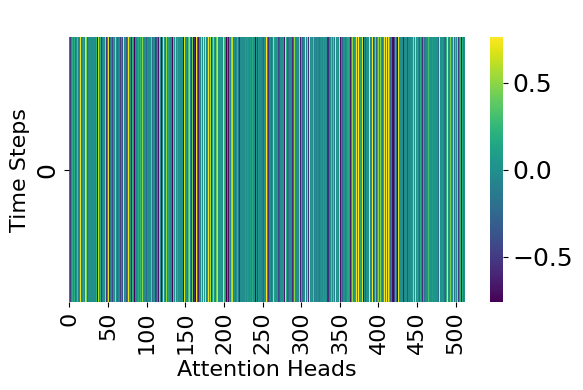

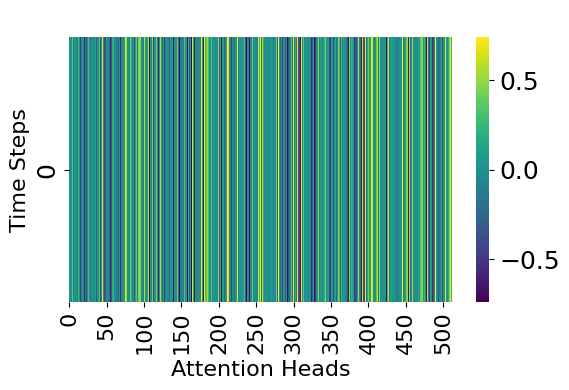

In [ ]:
##### attentionplotcicIoT2023   lastest
# Attentionplot cicIoT2023
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
import os
from keras.models import Model
from keras.utils import to_categorical

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
# Define paths
model_checkpoint = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'

# Load the model
gru_attention_model = tf.keras.models.load_model(model_checkpoint)

# Load data
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Sanity checks
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("Model Input Shape:", gru_attention_model.input_shape)
print("Model Output Shape:", gru_attention_model.output_shape)

# One-hot encode Y_test if necessary
num_classes = 8  # Number of output classes in your model
Y_test_one_hot = to_categorical(Y_test, num_classes=num_classes)

# Prepare attention model
attention_model = Model(inputs=gru_attention_model.input, outputs=gru_attention_model.get_layer('attention').output)

# Choose a small subset of samples to visualize
sample_indices = [0, 1]  # Adjust indices to visualize different samples
X_test_subset = X_test[sample_indices]

# Predict attention weights for the subset
with tf.device('/CPU:0'):  # Force execution on CPU to avoid CuDNN issues
    attention_weights_subset = attention_model.predict(X_test_subset, batch_size=1)
# selected_time_step = 0
# Visualize attention weights for selected samples
for i, sample_attention_weights in enumerate(attention_weights_subset):
    plt.figure(figsize=(6.0, 4.0))
    ax= sns.heatmap(
        sample_attention_weights,
        cmap="viridis",
        cbar=True,
        # xticklabels=np.arange(0, sample_attention_weights.shape[1], step=33),
        yticklabels=np.arange(0, sample_attention_weights.shape[0], step=33)
    )

    # Access the colorbar and adjust tick labels
    colorbar = ax.collections[0].colorbar  # Get the colorbar associated with the heatmap
    colorbar.ax.tick_params(labelsize=18)  # Set the tick label size
    colorbar.set_label('', fontsize=18)  # Set label size for colorbar


    plt.title(f' ', fontsize=18)
    plt.xlabel('Attention Heads', fontsize=16)
    plt.ylabel('Time Steps', fontsize=16)
    # plt.xticks(np.arange(0,sample_attention_weights.shape[0],step=33),fontsize=16,rotation=90)
    tick_step = 50
    tick_positions = np.arange(0, sample_attention_weights.shape[1], step=tick_step)
    plt.xticks(tick_positions,labels=[str(pos) for pos in tick_positions],fontsize=16,rotation=90)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    # Save each plot
    output_path = os.path.join(plot_directory, f'Attention_Weights_Heatmap_2023{sample_indices[i]}.jpeg')
    plt.savefig(output_path, format='jpeg')
    plt.show()


In [2]:
import tensorflow as tf

!pip install tensorflow==2.15.0


print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully unin

2.18.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1068632655190083606
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3228984131475076096
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


X_test: (9337316, 1, 30)
Y_test: (9337316,)
Model Input Shape: (None, 1, 30)
Model Output Shape: (None, 8)
4/4 [==============================] - 4s 7ms/step


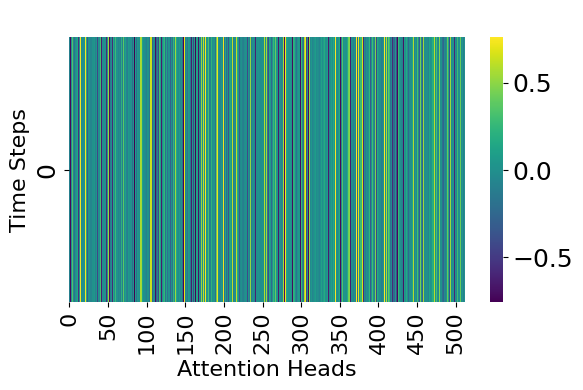

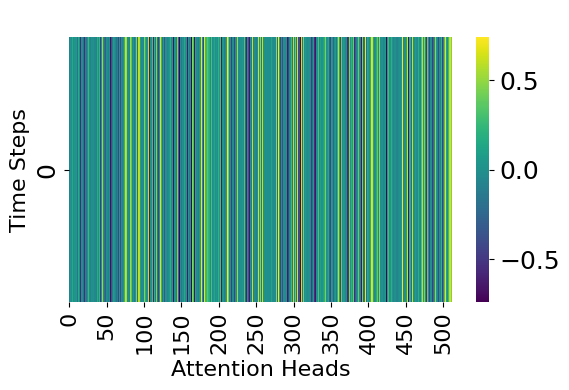

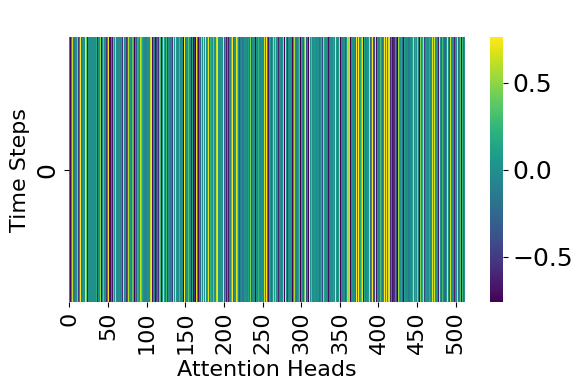

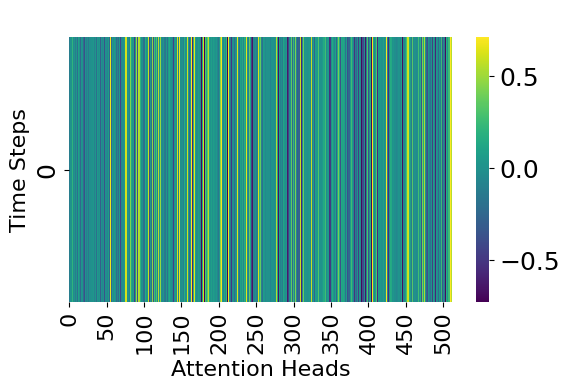

In [2]:
### April 2025 Attention plot
##### attentionplotcicIoT2023   lastest
# Attentionplot cicIoT2023
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
import os
from keras.models import Model
from keras.utils import to_categorical

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
# Define paths
model_checkpoint = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'

# Load the model
gru_attention_model = tf.keras.models.load_model(model_checkpoint)

# Load data
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Sanity checks
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("Model Input Shape:", gru_attention_model.input_shape)
print("Model Output Shape:", gru_attention_model.output_shape)

# One-hot encode Y_test if necessary
num_classes = 8  # Number of output classes in your model
Y_test_one_hot = to_categorical(Y_test, num_classes=num_classes)

# Prepare attention model
attention_model = Model(inputs=gru_attention_model.input, outputs=gru_attention_model.get_layer('attention').output)

# Choose a small subset of samples to visualize
sample_indices = [32,33,34,35]  # Adjust indices to visualize different samples
X_test_subset = X_test[sample_indices]

# Predict attention weights for the subset
with tf.device('/CPU:0'):  # Force execution on CPU to avoid CuDNN issues
    attention_weights_subset = attention_model.predict(X_test_subset, batch_size=1)
# selected_time_step = 0
# Visualize attention weights for selected samples
for i, sample_attention_weights in enumerate(attention_weights_subset):
    plt.figure(figsize=(6.0, 4.0))
    ax= sns.heatmap(
        sample_attention_weights,
        cmap="viridis",
        cbar=True,
        # xticklabels=np.arange(0, sample_attention_weights.shape[1], step=33),
        yticklabels=np.arange(0, sample_attention_weights.shape[0], step=33)
    )

    # Access the colorbar and adjust tick labels
    colorbar = ax.collections[0].colorbar  # Get the colorbar associated with the heatmap
    colorbar.ax.tick_params(labelsize=18)  # Set the tick label size
    colorbar.set_label('', fontsize=18)  # Set label size for colorbar


    plt.title(f' ', fontsize=18)
    plt.xlabel('Attention Heads', fontsize=16)
    plt.ylabel('Time Steps', fontsize=16)
    # plt.xticks(np.arange(0,sample_attention_weights.shape[0],step=33),fontsize=16,rotation=90)
    tick_step = 50
    tick_positions = np.arange(0, sample_attention_weights.shape[1], step=tick_step)
    plt.xticks(tick_positions,labels=[str(pos) for pos in tick_positions],fontsize=16,rotation=90)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    # Save each plot
    output_path = os.path.join(plot_directory, f'Attention_Weights_Heatmap_2025{sample_indices[i]}.jpeg')
    plt.savefig(output_path, format='jpeg')
    plt.show()


X_test: (9337316, 1, 30)
Y_test: (9337316,)
Model Input Shape: (None, 1, 30)
Model Output Shape: (None, 8)
4/4 [==============================] - 1s 3ms/step


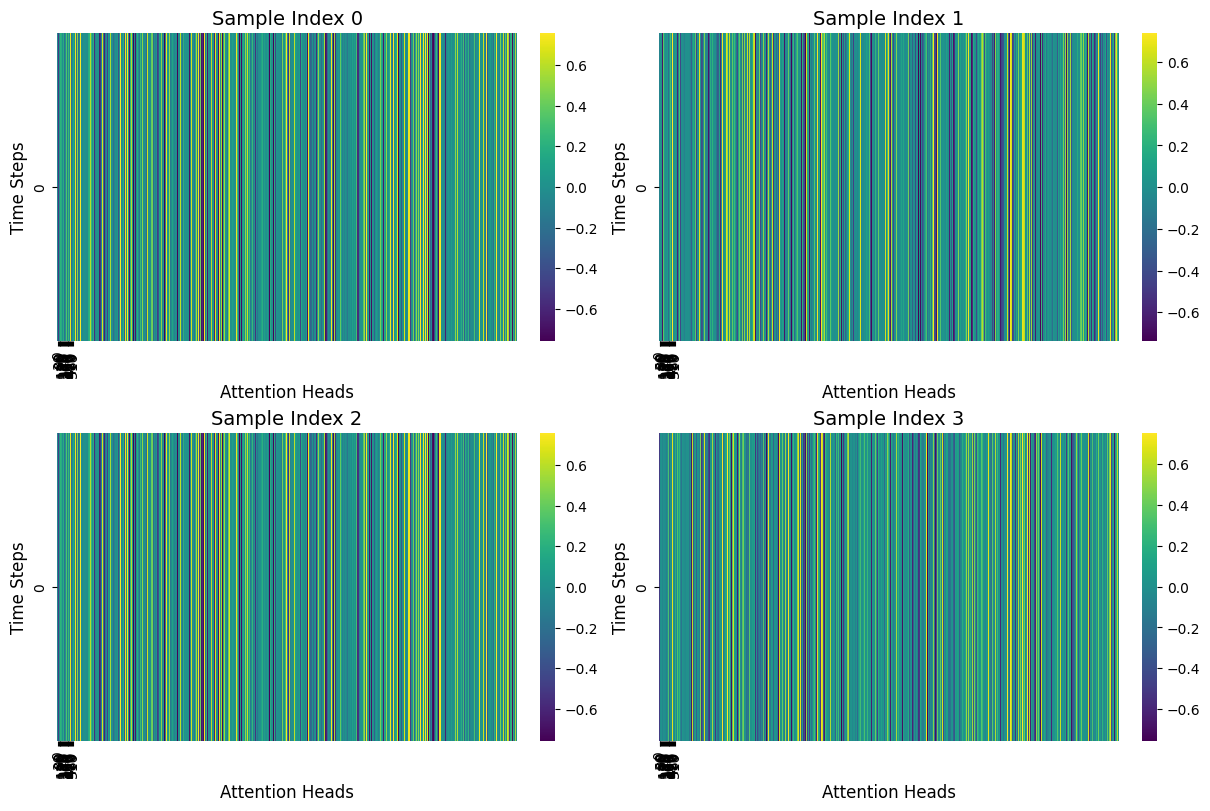

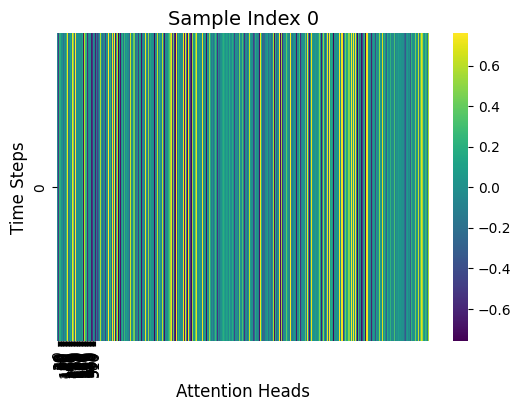

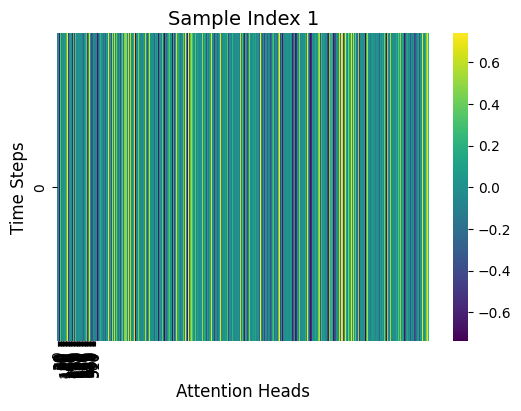

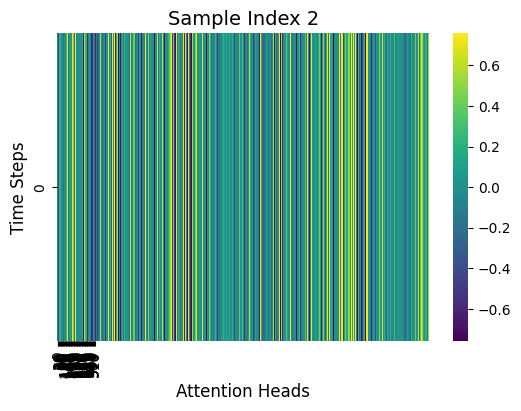

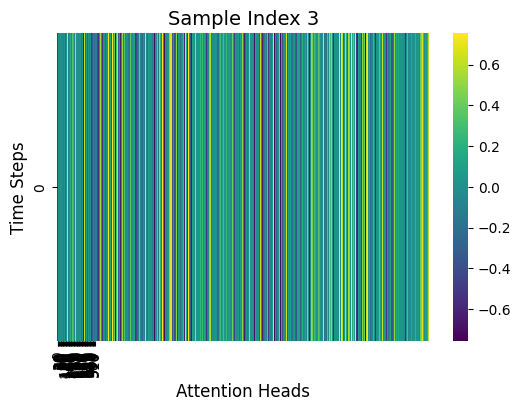

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from keras.models import Model
from keras.utils import to_categorical

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
model_checkpoint = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'

# Load the model
gru_attention_model = tf.keras.models.load_model(model_checkpoint)

# Load data
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Sanity checks
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("Model Input Shape:", gru_attention_model.input_shape)
print("Model Output Shape:", gru_attention_model.output_shape)

# Prepare attention model
attention_model = Model(inputs=gru_attention_model.input, outputs=gru_attention_model.get_layer('attention').output)

# Select a few samples to display
sample_indices = [0, 1, 2, 3]  # Four samples for visualization
X_test_subset = X_test[sample_indices]

# Predict attention weights for the subset
with tf.device('/CPU:0'):  # Force execution on CPU to avoid CuDNN issues
    attention_weights_subset = attention_model.predict(X_test_subset, batch_size=1)

# Plot attention weights for selected samples
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten axes for easier indexing

for i, sample_attention_weights in enumerate(attention_weights_subset):
    ax = axes[i]
    sns.heatmap(
        sample_attention_weights,
        cmap="viridis",
        cbar=True,
        ax=ax,
        xticklabels=np.arange(0, sample_attention_weights.shape[1], step=30),  # Properly spaced x-ticks
        yticklabels=np.arange(0, sample_attention_weights.shape[0], step=30)  # Properly spaced y-ticks
    )
    ax.set_title(f'Sample Index {sample_indices[i]}', fontsize=14)
    ax.set_xlabel('Attention Heads', fontsize=12)
    ax.set_ylabel('Time Steps', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)  # Adjust x-tick size and rotation
    ax.tick_params(axis='y', labelsize=10)

# Save the entire figure
output_path = os.path.join(plot_directory, 'Attention_Weights_Heatmaps_Grid.jpeg')
plt.savefig(output_path, format='jpeg', dpi=300)  # Save with high resolution
plt.show()

# Save individual plots (optional)
for i, sample_attention_weights in enumerate(attention_weights_subset):
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        sample_attention_weights,
        cmap="viridis",
        cbar=True,
        xticklabels=np.arange(0, sample_attention_weights.shape[1], step=10),
        yticklabels=np.arange(0, sample_attention_weights.shape[0], step=10)
    )
    plt.title(f'Sample Index {sample_indices[i]}', fontsize=14)
    plt.xlabel('Attention Heads', fontsize=12)
    plt.ylabel('Time Steps', fontsize=12)
    # plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    individual_output_path = os.path.join(plot_directory, f'Attention_Weights_Heatmap_2023{sample_indices[i]}.jpeg')
    plt.savefig(individual_output_path, format='jpeg', dpi=300)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from keras.models import Model
from keras.utils import to_categorical
from matplotlib.ticker import MaxNLocator  # For controlling the number of ticks

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Directory for saving plots
save_dir = '/content/drive/MyDrive/IDS-Research/CICIoT2023_plots_train_test_set'
model_checkpoint = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_CICIoT2023_0814.h5'

# Load the model
gru_attention_model = tf.keras.models.load_model(model_checkpoint)

# Load data
X_test = np.load(os.path.join(save_dir, 'X_test.npy'))
Y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Sanity checks
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("Model Input Shape:", gru_attention_model.input_shape)
print("Model Output Shape:", gru_attention_model.output_shape)

# Prepare attention model
attention_model = Model(inputs=gru_attention_model.input, outputs=gru_attention_model.get_layer('attention').output)

# Select a few samples to display
sample_indices = [0, 1, 2, 3]  # Four samples for visualization
X_test_subset = X_test[sample_indices]

# Predict attention weights for the subset
with tf.device('/CPU:0'):  # Force execution on CPU to avoid CuDNN issues
    attention_weights_subset = attention_model.predict(X_test_subset, batch_size=16)

# Plot attention weights for selected samples
for i, sample_attention_weights in enumerate(attention_weights_subset):
    plt.figure(figsize=(6, 4))  # Individual figure size
    sns.heatmap(
        sample_attention_weights,
        cmap="viridis",
        cbar=True,
        xticklabels=True,  # Default x-tick labels
        yticklabels=True   # Default y-tick labels
    )
    plt.title(f'Sample Index {sample_indices[i]}', fontsize=14)
    plt.xlabel('Attention Heads', fontsize=12)
    plt.ylabel('Time Steps', fontsize=12)

    # Calculate and print total x-ticks
    num_xticks = sample_attention_weights.shape[1]
    print(f"Sample {sample_indices[i]}: Total x-ticks = {num_xticks}")

    # Adjust x-ticks: Use np.arange() to control step size
    step_size = 32  # Initial step size
    x_ticks = np.arange(0, num_xticks, step_size)
    plt.xticks(x_ticks, fontsize=10, rotation=45)  # Rotate and adjust x-tick size

    # Use MaxNLocator to control tick labels display
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks
    ax.set_xticks(x_ticks)

    # Adjust y-ticks (optional)
    plt.yticks(fontsize=10)

    # Adjust colormap label (make it larger)
    cbar = plt.gca().collections[0].colorbar
    cbar.set_label('Attention Weights', fontsize=14)

    # Adjust the spacing around the plot to avoid clipping of tick labels
    plt.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.9)

    # Save the figure
    individual_output_path = os.path.join(plot_directory, f'Attention_Weights_Heatmap_2023{sample_indices[i]}.jpeg')
    plt.savefig(individual_output_path, format='jpeg', dpi=300)
    plt.show()


ValueError: Unrecognized keyword arguments passed to LSTM: {'time_major': False}

In [ ]:
### modifierd GRU -- 5 classes , reduce and SMOTE balancing , class weight , more GRU unit ... resume and attention heatmap
# Step 4: Model Definition, Training, and Evaluation
from keras.layers import Flatten, Dense, Dropout, GRU, Bidirectional, Input, Attention
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Define model architecture
dropout = 0.5
learning_rate = 1e-5
input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])

input_layer = Input(shape=input_shape)
x = Bidirectional(GRU(64, return_sequences=True))(input_layer)
x = Dropout(dropout)(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Dropout(dropout)(x)
x = Bidirectional(GRU(256, return_sequences=True))(x)
x = Dropout(dropout)(x)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([x, x])
x = Flatten()(attention_output)
output_layer = Dense(units=len(np.unique(y_train_resampled)), activation='softmax')(x)

bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=learning_rate)
bilstm_attention_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'], class_weight=class_weights)
bilstm_attention_model.summary()

# Define callbacks
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023_07_17.h5'
bilstm_attention_model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
callbacks = [bilstm_attention_model_checkpoint_callback, early_stopping, reduce_lr]

# Load the latest checkpoint if available
if os.path.exists(checkpoint_path):
    bilstm_attention_model.load_weights(checkpoint_path)

# Load previous training history if available
history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_history_17.npz'
if os.path.exists(history_path):
    previous_history = np.load(history_path)
    prev_accuracy = list(previous_history['accuracy'])
    prev_val_accuracy = list(previous_history['val_accuracy'])
    prev_loss = list(previous_history['loss'])
    prev_val_loss = list(previous_history['val_loss'])
    del previous_history  # Free up memory
else:
    prev_accuracy = []
    prev_val_accuracy = []
    prev_loss = []
    prev_val_loss = []

# Train the model
start_time = time.time()
bilstm_attention_model_history = bilstm_attention_model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=128, validation_data=(X_test, y_test), callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Clean up memory by deleting training data
del X_train_resampled, y_train_resampled

# Merge histories
accuracy = prev_accuracy + bilstm_attention_model_history.history['accuracy']
val_accuracy = prev_val_accuracy + bilstm_attention_model_history.history['val_accuracy']
loss = prev_loss + bilstm_attention_model_history.history['loss']
val_loss = prev_val_loss + bilstm_attention_model_history.history['val_loss']

# Save merged history
np.savez_compressed(history_path, accuracy=accuracy, val_accuracy=val_accuracy, loss=loss, val_loss=val_loss)

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Plot accuracy
plt.plot(accuracy, color="green", marker='o')
plt.plot(val_accuracy, color="blue", marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(loss, color="green", marker='o')
plt.plot(val_loss, color="blue", marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Clean up memory by deleting history variables
del accuracy, val_accuracy, loss, val_loss

# Evaluate the model on test data
test_loss, test_accuracy = bilstm_attention_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Extract and plot attention weights
attention_model = Model(inputs=input_layer, outputs=attention_output)
attention_weights = attention_model.predict(X_test)

# Select a sample to visualize attention weights
sample_index = 0
sample_attention_weights = attention_weights[sample_index]

plt.figure(figsize=(10, 8))
sns.heatmap(sample_attention_weights, cmap='viridis')
plt.title('Attention Weights Heatmap for Sample Index {}'.format(sample_index))
plt.xlabel('Attention Heads')
plt.ylabel('Time Steps')
plt.show()

# Clean up memory by deleting attention-related variables
del attention_weights, sample_attention_weights, attention_model


In [ ]:
# ===>GRU WITH smote reduced ... Model Definition, Training, and Evaluation
from keras.layers import Flatten, Dense, Dropout, GRU, Bidirectional, Input, Attention
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Define model architecture
dropout = 0.5
learning_rate = 1e-5
input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])

input_layer = Input(shape=input_shape)
x = Bidirectional(GRU(64, return_sequences=True))(input_layer)
x = Dropout(dropout)(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Dropout(dropout)(x)
x = Bidirectional(GRU(256, return_sequences=True))(x)
x = Dropout(dropout)(x)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([x, x])
x = Flatten()(attention_output)
output_layer = Dense(units=len(np.unique(y_train_resampled)), activation='softmax')(x)

bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=learning_rate)
bilstm_attention_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'], class_weight=class_weights)
bilstm_attention_model.summary()

# Define callbacks
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023_07_17.h5'
bilstm_attention_model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
callbacks = [bilstm_attention_model_checkpoint_callback, early_stopping, reduce_lr]

# Load the latest checkpoint if available
if os.path.exists(checkpoint_path):
    bilstm_attention_model.load_weights(checkpoint_path)

# Load previous training history if available
history_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_history_17.npz'
if os.path.exists(history_path):
    previous_history = np.load(history_path)
    prev_accuracy = list(previous_history['accuracy'])
    prev_val_accuracy = list(previous_history['val_accuracy'])
    prev_loss = list(previous_history['loss'])
    prev_val_loss = list(previous_history['val_loss'])
    del previous_history  # Free up memory
else:
    prev_accuracy = []
    prev_val_accuracy = []
    prev_loss = []
    prev_val_loss = []

# Train the model
start_time = time.time()
bilstm_attention_model_history = bilstm_attention_model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=128, validation_data=(X_test, y_test), callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Clean up memory by deleting training data
del X_train_resampled, y_train_resampled

# Merge histories
accuracy = prev_accuracy + bilstm_attention_model_history.history['accuracy']
val_accuracy = prev_val_accuracy + bilstm_attention_model_history.history['val_accuracy']
loss = prev_loss + bilstm_attention_model_history.history['loss']
val_loss = prev_val_loss + bilstm_attention_model_history.history['val_loss']

# Save merged history
np.savez_compressed(history_path, accuracy=accuracy, val_accuracy=val_accuracy, loss=loss, val_loss=val_loss)

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Plot accuracy
plt.plot(accuracy, color="green", marker='o')
plt.plot(val_accuracy, color="blue", marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(loss, color="green", marker='o')
plt.plot(val_loss, color="blue", marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Clean up memory by deleting history variables
del accuracy, val_accuracy, loss, val_loss

# Evaluate the model on test data
test_loss, test_accuracy = bilstm_attention_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Extract and plot attention weights
attention_model = Model(inputs=input_layer, outputs=attention_output)
attention_weights = attention_model.predict(X_test)

# Select a sample to visualize attention weights
sample_index = 0
sample_attention_weights = attention_weights[sample_index]

plt.figure(figsize=(10, 8))
sns.heatmap(sample_attention_weights, cmap='viridis')
plt.title('Attention Weights Heatmap for Sample Index {}'.format(sample_index))
plt.xlabel('Attention Heads')
plt.ylabel('Time Steps')
plt.show()

# Clean up memory by deleting attention-related variables
del attention_weights, sample_attention_weights, attention_model


In [ ]:
## model plotting GRU-1 ... 5 classes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Attention
from sklearn.preprocessing import LabelEncoder

# del X_train,history,gru_attention_model
# Define file paths -BI_GRU_Attention_MDcic2023_history_17.npz  --- BI_GRU_Attention_MD_cic2023_07_17.h5
model_filepath = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023_07_17.h5'
history_filepath = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_history_17.npz'

# Load the model
gru_attention_model = load_model(model_filepath)

# Load the training history
history = np.load(history_filepath)
accuracy = history['accuracy'][2:]
val_accuracy = history['val_accuracy'][2:]
loss = history['loss'][2:]
val_loss = history['val_loss'][2:]

# Load test and training sets if they are not already in memory
# Assuming X_test, y_test, and encoder.classes_ are available

# Make predictions
y_pred_probs = gru_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy, color="green", marker='o', label='Training Accuracy')
plt.plot(val_accuracy, color="blue", marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss, color="green", marker='o', label='Training Loss')
plt.plot(val_loss, color="blue", marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)


# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


ValueError: Unrecognized keyword arguments passed to GRU: {'time_major': False}

In [ ]:
# # GRU WITH REDUCED class number - and lr scheduler
# import time
# import pandas as pd
# import numpy as np
# import os
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split
# from keras.layers import Flatten, Dense, Dropout, LSTM, Bidirectional, Input, Attention, GRU
# from keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# from tensorflow.keras.optimizers import Adam
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# # Assuming X_train, y_train, X_test, y_test, and encoder are already defined

# # Model architecture
# dropout = 0.5
# learning_rate = 1e-5

# input_shape = (X_train.shape[1], X_train.shape[2])

# input_layer = Input(shape=input_shape)

# x = Bidirectional(GRU(128, return_sequences=True))(input_layer)
# x = Dropout(dropout)(x)
# x = Bidirectional(GRU(256, return_sequences=True))(x)
# x = Dropout(dropout)(x)

# # Attention mechanism
# attention = Attention()([x, x])
# x = Flatten()(attention)

# # Output layer with units equal to the number of unique classes in y_train
# output_layer = Dense(units=len(np.unique(y_train)), activation='softmax')(x)

# # Compile the model
# bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)
# optimizer = Adam(learning_rate=learning_rate)
# bilstm_attention_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Display model summary
# bilstm_attention_model.summary()

# # Define callbacks
# bilstm_attention_model_checkpoint_callback = ModelCheckpoint(
#     filepath='/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023_07_17.h5',
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * 0.9

# lr_scheduler = LearningRateScheduler(scheduler)
# callbacks = [bilstm_attention_model_checkpoint_callback, early_stopping, reduce_lr, lr_scheduler]

# # Train the model
# start_time = time.time()
# bilstm_attention_model_history = bilstm_attention_model.fit(X_train, y_train, epochs=40, batch_size=64,
#                                                             validation_data=(X_test, y_test), callbacks=callbacks)
# end_time = time.time()
# training_time = end_time - start_time
# print("Training time: {:.2f} seconds".format(training_time))

# # Save history
# np.savez_compressed('/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MDcic2023_history_17.npz',
#                     accuracy=bilstm_attention_model_history.history['accuracy'],
#                     val_accuracy=bilstm_attention_model_history.history['val_accuracy'],
#                     loss=bilstm_attention_model_history.history['loss'],
#                     val_loss=bilstm_attention_model_history.history['val_loss'])

# # Make predictions
# y_pred_probs = bilstm_attention_model.predict(X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Classification report
# class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
# print("Classification Report:")
# print(class_report)

# # Plot accuracy
# plt.plot(bilstm_attention_model_history.history['accuracy'][1:], color="green", marker='o')
# plt.plot(bilstm_attention_model_history.history['val_accuracy'][1:], color="blue", marker='o')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='lower right')
# plt.show()

# # Plot loss
# plt.plot(bilstm_attention_model_history.history['loss'][1:], color="green", marker='o')
# plt.plot(bilstm_attention_model_history.history['val_loss'][1:], color="blue", marker='o')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

# # Evaluate the model on test data
# test_loss, test_accuracy = bilstm_attention_model.evaluate(X_test, y_test)
# print('Test Accuracy:', test_accuracy)

# # Confusion matrix
# cm = confusion_matrix(y_test, y_pred, normalize='true')
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.show()

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# n_classes = len(encoder.classes_)
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curve for each class
# plt.figure(figsize=(10, 8))
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(encoder.classes_[i], roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()


## The weights for the Query (Wq), Key (Wk), and Value (Wv) matrices are initialized randomly. This is done using the add_weight method in the build function of the SelfAttention layer.
## These weights are trainable parameters and will be optimized during the training process.
# **Learning:**

# During training, the backpropagation algorithm adjusts these weights to minimize the loss function.
# As the model trains, it learns the optimal values for these weights to effectively capture the relationships within the input data.
# The optimization of these weights is guided by the loss gradient, which is computed based on the difference between the model's predictions and the true labels.


In [ ]:
## reduced calss with custome attention -- no resume capability
import time
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Dense, Dropout, LSTM, Bidirectional, Input, Layer, BatchNormalization
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Custom Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wq = self.add_weight(name="Wq", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(name="Wk", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(name="Wv", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.Wq)
        k = tf.matmul(x, self.Wk)
        v = tf.matmul(x, self.Wv)

        qk = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits = qk / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(weights, v)
        return output  # Return only the output

# Data preparation and model configuration
dropout = 0.4
learning_rate = 5e-5  # Reduced learning rate for fine-tuning

# Reshape data for LSTM (assuming each row is a timestamp)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

input_shape = (X_train.shape[1], X_train.shape[2])

input_layer = Input(shape=input_shape)
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)

# Self-Attention mechanism
attention_output = SelfAttention()(x)
x = Flatten()(attention_output)

# Output layer with units equal to the number of unique classes in y_train
output_layer = Dense(units=len(np.unique(y_train)), activation='softmax')(x)

# Compile the model
bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)  # Model outputs only predictions
optimizer = Adam(learning_rate=learning_rate)
bilstm_attention_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
bilstm_attention_model.summary()

# Define callbacks
bilstm_attention_model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MD_cic2023_07_06.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [bilstm_attention_model_checkpoint_callback, early_stopping, reduce_lr]

# Train the model
start_time = time.time()
bilstm_attention_model_history = bilstm_attention_model.fit(X_train, y_train, epochs=20, batch_size=128,
                                                            validation_data=(X_test, y_test), callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Save history
np.savez_compressed('/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MDcic2023_history_07.npz',
                    accuracy=bilstm_attention_model_history.history['accuracy'],
                    val_accuracy=bilstm_attention_model_history.history['val_accuracy'],
                    loss=bilstm_attention_model_history.history['loss'],
                    val_loss=bilstm_attention_model_history.history['val_loss'])

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Plot accuracy
plt.plot(bilstm_attention_model_history.history['accuracy'][1:], color="green", marker='o')
plt.plot(bilstm_attention_model_history.history['val_accuracy'][1:], color="blue", marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(bilstm_attention_model_history.history['loss'][1:], color="green", marker='o')
plt.plot(bilstm_attention_model_history.history['val_loss'][1:], color="blue", marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = bilstm_attention_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Function to plot attention weights
def plot_attention_weights(attention_weights, sample_index):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights[sample_index].reshape(1, -1), cmap='viridis', cbar=True)
    plt.title(f'Attention Weights for Sample {sample_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Attention Weight')
    plt.show()

# Extract attention weights
attention_weights_test = bilstm_attention_model.predict(X_test, batch_size=128)[1]

# Plot attention weights for a few samples
for sample_index in range(5):
    plot_attention_weights(attention_weights_test, sample_index)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 46)]           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 256)            179200    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 1, 256)            1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 512)            1050624   
 onal)                                                           
                                                             

KeyboardInterrupt: 

In [ ]:
# Model with resume capability ---
import time
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Dense, Dropout, LSTM, Bidirectional, Input, Layer, BatchNormalization
from keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Custom Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wq = self.add_weight(name="Wq", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(name="Wk", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(name="Wv", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.Wq)
        k = tf.matmul(x, self.Wk)
        v = tf.matmul(x, self.Wv)

        qk = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits = qk / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(weights, v)
        return output  # Return only the output

# Data preparation and model configuration
dropout = 0.4
learning_rate = 5e-5 # Reduced learning rate for fine-tuning

# Reshape data for LSTM (assuming each row is a timestamp)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

input_shape = (X_train.shape[1], X_train.shape[2])

input_layer = Input(shape=input_shape)
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)

# Self-Attention mechanism
attention_output = SelfAttention()(x)
x = Flatten()(attention_output)

# Output layer with units equal to the number of unique classes in y_train
output_layer = Dense(units=len(np.unique(y_train)), activation='softmax')(x)

# Compile the model
bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)  # Model outputs only predictions
optimizer = Adam(learning_rate=learning_rate)
bilstm_attention_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
bilstm_attention_model.summary()

# Define the learning rate schedule function
# def lr_schedule(epoch, lr):
#     if epoch < 15:
#         return 5e-5
#     elif epoch < 25:
#         return 2e-5
#     else:
#         return 1e-5

# Define callbacks
checkpoint_filepath = '/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MD_cic202307_14.h5'
bilstm_attention_model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,  # Save only the weights
    verbose=1
)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [bilstm_attention_model_checkpoint_callback, early_stopping, reduce_lr]

# Load the model weights if checkpoint exists
if os.path.exists(checkpoint_filepath):
    bilstm_attention_model.load_weights(checkpoint_filepath)
    print("Checkpoint loaded successfully! and resuming from there ")
else:
   print("No check point found The model start from scratch ")


# Train the model
start_time = time.time()
bilstm_attention_model_history = bilstm_attention_model.fit(X_train, y_train, epochs=40, batch_size=128,  # Increased to 40 epochs
                                                            validation_data=(X_test, y_test), callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Save history periodically
history_filepath = '/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MDcic2023_history07_14.npz'
np.savez_compressed(history_filepath,
                    accuracy=bilstm_attention_model_history.history['accuracy'],
                    val_accuracy=bilstm_attention_model_history.history['val_accuracy'],
                    loss=bilstm_attention_model_history.history['loss'],
                    val_loss=bilstm_attention_model_history.history['val_loss'])

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Plot accuracy
plt.plot(bilstm_attention_model_history.history['accuracy'][1:], color="green", marker='o')
plt.plot(bilstm_attention_model_history.history['val_accuracy'][1:], color="blue", marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(bilstm_attention_model_history.history['loss'][1:], color="green", marker='o')
plt.plot(bilstm_attention_model_history.history['val_loss'][1:], color="blue", marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = bilstm_attention_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Function to plot attention weights
def plot_attention_weights(attention_weights, sample_index):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights[sample_index].reshape(1, -1), cmap='viridis', cbar=True)
    plt.title(f'Attention Weights for Sample {sample_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Attention Weight')
    plt.show()

# Extract attention weights
attention_weights_test = bilstm_attention_model.predict(X_test, batch_size=128)[1]

# Plot attention weights for a few samples
for sample_index in range(5):
    plot_attention_weights(attention_weights_test, sample_index)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 46)]           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 256)            179200    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 1, 256)            1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 512)            1050624   
 onal)                                                           
                                                             

KeyboardInterrupt: 

In [ ]:
# Plotting loss, accuracy, confusion matrix, ROC curve, and attention weights from saved model
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load the saved history
history_path = '/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MDcic2023_new_history_11.npz'
loaded_history = np.load(history_path)

# Extract the relevant metrics
accuracy = loaded_history['accuracy']
val_accuracy = loaded_history['val_accuracy']
loss = loaded_history['loss']
val_loss = loaded_history['val_loss']

# Load the saved model
saved_model_path = '/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MD_cic2023_07_11_new.h5'
bilstm_attention_model = load_model(saved_model_path, custom_objects={'SelfAttention': SelfAttention})

# Display model summary
bilstm_attention_model.summary()

# Ensure labels are in correct format for LSTM
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

def plot_loss_accuracy(accuracy, val_accuracy, loss, val_loss):
    plt.figure(figsize=(10, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy', color='green', marker='o')
    plt.plot(val_accuracy, label='Validation Accuracy', color='blue', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', color='green', marker='o')
    plt.plot(val_loss, label='Validation Loss', color='blue', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

def plot_roc_curve(y_true, y_pred_probs, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = len(classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def plot_class_distribution(y, classes):
    class_counts = pd.Series(y).value_counts().sort_index()

    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.show()

def plot_attention_weights(model, X_test, sample_index):
    attention_layer = model.get_layer("self_attention")
    attention_model = Model(inputs=model.input, outputs=attention_layer.output)
    attention_weights = attention_model.predict(X_test)

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights[sample_index].reshape(1, -1), cmap='viridis', cbar=True)
    plt.title(f'Attention Weights for Sample {sample_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Attention Weight')
    plt.show()

# Define unique classes based on the dictionary used during training
unique_classes = sorted(set(y_test))  # Ensure classes are unique and sorted

# Plot loss and accuracy
plot_loss_accuracy(accuracy, val_accuracy, loss, val_loss)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=unique_classes)
print("Classification Report:")
print(class_report)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, unique_classes)

# Plot ROC curve
plot_roc_curve(y_test, y_pred_probs, unique_classes)

# Plot class distribution
plot_class_distribution(y_test, unique_classes)

# Plot attention weights for a few samples
for sample_index in range(5):
    plot_attention_weights(bilstm_attention_model, X_test, sample_index)


In [ ]:
# Model with transformer
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Reshape data for Transformer

# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
input_shape = (X_train.shape[1], X_train.shape[2])

# Transformer Encoder Block

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Model architecture
dropout = 0.4
learning_rate = 5e-5

input_layer = Input(shape=input_shape)
x = transformer_encoder(input_layer, head_size=256, num_heads=4, ff_dim=4, dropout=dropout)
x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=dropout)

x = Flatten()(x)
output_layer = Dense(units=len(np.unique(y_train)), activation='softmax')(x)

transformer_model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=learning_rate)
transformer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
transformer_model.summary()

# Define callbacks
transformer_model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/IDS-Research/Transformer_MD_cic2023_07_11.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [transformer_model_checkpoint_callback, early_stopping, reduce_lr]

# Train the model
start_time = time.time()
transformer_model_history = transformer_model.fit(X_train, y_train, epochs=20, batch_size=128,
                                                  validation_data=(X_test, y_test), callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Save history
np.savez_compressed('/content/drive/MyDrive/IDS-Research/Transformer_MDcic2023_history_11.npz',
                    accuracy=transformer_model_history.history['accuracy'],
                    val_accuracy=transformer_model_history.history['val_accuracy'],
                    loss=transformer_model_history.history['loss'],
                    val_loss=transformer_model_history.history['val_loss'])

# Make predictions
y_pred_probs = transformer_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Plot accuracy
plt.plot(transformer_model_history.history['accuracy'][1:], color="green", marker='o')
plt.plot(transformer_model_history.history['val_accuracy'][1:], color="blue", marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(transformer_model_history.history['loss'][1:], color="green", marker='o')
plt.plot(transformer_model_history.history['val_loss'][1:], color="blue", marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = transformer_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 46)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 1, 46)                191534    ['input_2[0][0]',             
 iHeadAttention)                                                     'input_2[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 1, 46)                0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 1, 46)                92        ['dropout_2[0][0]']     

KeyboardInterrupt: 

In [ ]:
### Model with combined samplying and class weight
from sklearn.utils import class_weight
import time
import os
from keras.layers import Flatten, Dense, Dropout, LSTM, Bidirectional, Input, Layer, BatchNormalization
from keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Custom Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wq = self.add_weight(name="Wq", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(name="Wk", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(name="Wv", shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                  initializer='glorot_uniform', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.Wq)
        k = tf.matmul(x, self.Wk)
        v = tf.matmul(x, self.Wv)

        qk = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits = qk / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(weights, v)
        return output  # Return only the output

# Data preparation and model configuration
dropout = 0.4
learning_rate = 5e-5  # Reduced learning rate for fine-tuning

# Reshape data for LSTM (assuming each row is a timestamp)
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

input_shape = (X_train.shape[1], X_train.shape[2])

input_layer = Input(shape=input_shape)
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)

# Self-Attention mechanism
attention_output = SelfAttention()(x)
x = Flatten()(attention_output)

# Output layer with units equal to the number of unique classes in y_train
output_layer = Dense(units=len(np.unique(y_train)), activation='softmax')(x)

# Compile the model
bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)  # Model outputs only predictions
optimizer = Adam(learning_rate=learning_rate)
bilstm_attention_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
bilstm_attention_model.summary()

# Define callbacks
checkpoint_filepath = '/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MD_cic202307_15.h5'
bilstm_attention_model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,  # Save only the weights
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [bilstm_attention_model_checkpoint_callback, early_stopping, reduce_lr]

# Load the model weights if checkpoint exists
if os.path.exists(checkpoint_filepath):
    bilstm_attention_model.load_weights(checkpoint_filepath)
    print("Checkpoint loaded successfully! Resuming from there.")
else:
    print("No checkpoint found. The model will start from scratch.")

# Train the model with class weights
start_time = time.time()
bilstm_attention_model_history = bilstm_attention_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=128,  # Increased to 40 epochs
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights  # Include class weights
)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Save history periodically
history_filepath = '/content/drive/MyDrive/IDS-Research/BI_LSTM_Attention_MDcic2023_history07_15.npz'
np.savez_compressed(history_filepath,
                    accuracy=bilstm_attention_model_history.history['accuracy'],
                    val_accuracy=bilstm_attention_model_history.history['val_accuracy'],
                    loss=bilstm_attention_model_history.history['loss'],
                    val_loss=bilstm_attention_model_history.history['val_loss'])

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Plot accuracy
plt.plot(bilstm_attention_model_history.history['accuracy'][1:], color="green", marker='o')
plt.plot(bilstm_attention_model_history.history['val_accuracy'][1:], color="blue", marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(bilstm_attention_model_history.history['loss'][1:], color="green", marker='o')
plt.plot(bilstm_attention_model_history.history['val_loss'][1:], color="blue", marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = bilstm_attention_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 46)]           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 256)            179200    
 onal)                                                           
                                                                 
 batch_normalization_2 (Bat  (None, 1, 256)            1024      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 1, 512)            1050624   
 onal)                                                           
                                                           

KeyboardInterrupt: 

In [ ]:
## transformer ewith resume
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Custom callback to save history at the end of every epoch
class HistorySaver(Callback):
    def __init__(self, history_file):
        super(HistorySaver, self).__init__()
        self.history_file = history_file

    def on_epoch_end(self, epoch, logs=None):
        # Save history to file
        if logs is not None:
            np.savez_compressed(self.history_file, **self.model.history.history)

# Load or initialize model
def load_or_initialize_model(model_file, input_shape, num_classes, learning_rate):
    if os.path.exists(model_file):
        print(f"Loading model from {model_file}")
        model = load_model(model_file)
    else:
        print("Initializing new model")
        input_layer = Input(shape=input_shape)
        x = transformer_encoder(input_layer, head_size=256, num_heads=4, ff_dim=4, dropout=0.4)
        x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.4)
        x = Flatten()(x)
        output_layer = Dense(units=num_classes, activation='softmax')(x)
        model = Model(inputs=input_layer, outputs=output_layer)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Data preprocessing and reshaping
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))
learning_rate = 5e-5

# Paths for saving model and history
model_file = '/content/drive/MyDrive/IDS-Research/Transformer_MD_cic2023_07_11.h5'
history_file = '/content/drive/MyDrive/IDS-Research/Transformer_MDcic2023_history_11.npz'

# Load or initialize model
transformer_model = load_or_initialize_model(model_file, input_shape, num_classes, learning_rate)
transformer_model.summary()

# Define callbacks
transformer_model_checkpoint_callback = ModelCheckpoint(
    filepath=model_file,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_saver = HistorySaver(history_file)

callbacks = [transformer_model_checkpoint_callback, early_stopping, reduce_lr, history_saver]

# Train the model
start_time = time.time()
transformer_model_history = transformer_model.fit(X_train, y_train, epochs=20, batch_size=128,
                                                  validation_data=(X_test, y_test), callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Save history after training
np.savez_compressed(history_file,
                    accuracy=transformer_model_history.history['accuracy'],
                    val_accuracy=transformer_model_history.history['val_accuracy'],
                    loss=transformer_model_history.history['loss'],
                    val_loss=transformer_model_history.history['val_loss'])

# Make predictions
y_pred_probs = transformer_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Plot accuracy
plt.plot(transformer_model_history.history['accuracy'][1:], color="green", marker='o')
plt.plot(transformer_model_history.history['val_accuracy'][1:], color="blue", marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(transformer_model_history.history['loss'][1:], color="green", marker='o')
plt.plot(transformer_model_history.history['val_loss'][1:], color="blue", marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = transformer_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, label_binarize
from itertools import cycle

# Assuming y_test and y_pred_probs are already defined
# Binarize the output
Num_classes = y_pred_probs.shape[1]
y_test_binarized = label_binarize(Y_test, classes=np.arange(Num_classes))

# Class names (modify these names as per your actual class names)
class_names = ['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(Num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= Num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves for each class, micro-average, and macro-average
plt.figure(figsize=(10, 8))  # Increase figure size for better visibility

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple', 'brown', 'pink', 'gray'])
linestyles = cycle(['-', '--', '-.', ':', '-', '--', '-.', ':'])
for i, (color, linestyle) in enumerate(zip(colors, linestyles)):
    plt.plot(fpr[i], tpr[i], color=color, linestyle=linestyle, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()


In [ ]:
####################
# Uninstall current versions of TensorFlow and Keras
!pip uninstall tensorflow keras -y

# Install specific compatible versions of TensorFlow and Keras
!pip install tensorflow==2.12 keras==2.12

# Check installed versions to confirm
import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1

TensorFlow version: 2.17.0
Keras version: 3.4.1


In [ ]:
###  original LSTM implemenation


### Data preparation for LSTM #############
# Reshape data for LSTM (assuming each row is a timestamp)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
############
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)
############
##### END OF data pereparation for LSTM ####
from keras.layers import LSTM, Input, Dense, Dropout, Bidirectional, Attention, Flatten
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import time
# Define LSTM model architecture
dropout = 0.5
learning_rate = 1e-5

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
input_layer = Input(shape=input_shape)
x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Dropout(dropout)(x)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([x, x])
x = Flatten()(attention_output)
output_layer = Dense(units=len(np.unique(y_train)), activation='softmax')(x)

bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=learning_rate)
bilstm_attention_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bilstm_attention_model.summary()

# Define callbacks
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023_08_07.h5'
bilstm_attention_model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
callbacks = [bilstm_attention_model_checkpoint_callback, early_stopping, reduce_lr]

# Train the model
start_time = time.time()
bilstm_attention_model_history = bilstm_attention_model.fit(X_train_reshaped, y_train, epochs=30, batch_size=128, validation_data=(X_test_reshaped, y_test), callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate class-wise metrics for LSTM
cm_lstm = confusion_matrix(y_test, y_pred)
accuracy_per_class_lstm = cm_lstm.diagonal() / cm_lstm.sum(axis=1)
precision_lstm, recall_lstm, f1_score_lstm, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
fpr_lstm = {}
for i in range(len(encoder.classes_)):
    fpr_lstm[i] = (cm_lstm[:, i].sum() - cm_lstm[i, i]) / cm_lstm.sum(axis=0)[i]

# Print class-wise metrics for LSTM
print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'FPR':<10}")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {accuracy_per_class_lstm[i]:<10.4f} {precision_lstm[i]:<10.4f} {recall_lstm[i]:<10.4f} {f1_score_lstm[i]:<10.4f} {fpr_lstm[i]:<10.4f}")

# Plot class-wise metrics for LSTM
metrics_data_lstm = {
    'Class': class_names,
    'Accuracy': accuracy_per_class_lstm,
    'Precision': precision_lstm,
    'Recall': recall_lstm,
    'F1-score': f1_score_lstm,
    'FPR': [fpr_lstm[i] for i in range(len(encoder.classes_))]
}

metrics_df_lstm = pd.DataFrame(metrics_data_lstm)
metrics_df_lstm.plot(kind='bar', x='Class', figsize=(8, 5))
plt.title('Class-wise Performance Metrics (LSTM)')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_LSTM.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_LSTM.jpeg'), format='jpeg', dpi=300)
plt.show()


(4774733, 1, 46)
(1193684, 1, 46)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 46)]      0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 1, 128)      56832       ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 dropout_3 (Dropout)            (None, 1, 128)       0           ['bidirectional_3[0][0]']        
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 1, 256)      26316

NameError: name 'confusion_matrix' is not defined

37303/37303 [==============================] - 115s 3ms/step
Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.76      0.80      0.78    170975
         Syn       0.99      0.14      0.25      2016
     NetBIOS       0.92      0.95      0.94    360000
         UDP       0.85      0.75      0.80    120000
       MSSQL       1.00      0.99      1.00     90000
     Portmap       0.75      0.90      0.82    275935
        LDAP       0.87      0.65      0.74    151483
      UDPLag       0.86      0.08      0.14     23275

    accuracy                           0.85   1193684
   macro avg       0.88      0.66      0.68   1193684
weighted avg       0.85      0.85      0.84   1193684

Class           Accuracy   Precision  Recall     F1-score   FPR       
BENIGN          0.8030     0.7633     0.8030     0.7827     0.2367    
Syn             0.1448     0.9898     0.1448     0.2527     0.0102    
NetBIOS         0.9542     0.9217     0.9542     0.9

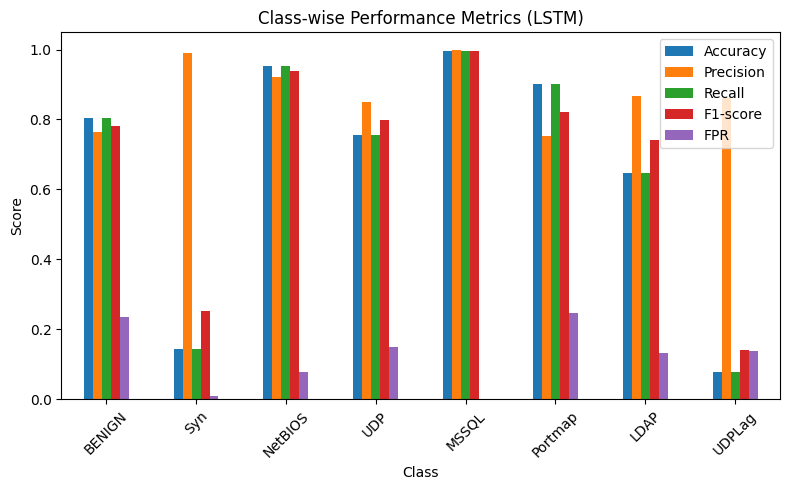

In [ ]:
### LSTM performance metrics
import os
import numpy as np
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023_08_07.h5'
bilstm_attention_model = load_model(checkpoint_path)

# Assuming X_test_reshaped and y_test are already loaded
# X_test_reshaped and y_test should be loaded as per your data pipeline

# Make predictions
y_pred_probs = bilstm_attention_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_names = ['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate per-class metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
fpr = {i: (cm[:, i].sum() - cm[i, i]) / cm.sum(axis=0)[i] for i in range(len(class_names))}

# Print per-class metrics
print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'FPR':<10}")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {accuracy_per_class[i]:<10.4f} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1_score[i]:<10.4f} {fpr[i]:<10.4f}")

# Calculate overall metrics
overall_accuracy = accuracy_score(y_test, y_pred)
overall_precision, overall_recall, overall_f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
overall_fpr = np.mean(list(fpr.values()))

# Print overall metrics
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-score: {overall_f1_score:.4f}")
print(f"Overall FPR: {overall_fpr:.4f}")

# Plot class-wise metrics
metrics_data = {
    'Class': class_names,
    'Accuracy': accuracy_per_class,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1_score,
    'FPR': [fpr[i] for i in range(len(class_names))]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.plot(kind='bar', x='Class', figsize=(8, 5))
plt.title('Class-wise Performance Metrics (LSTM)')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_LSTM.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_LSTM.jpeg'), format='jpeg', dpi=300)
plt.show()



Overall Accuracy: 0.9906
Overall Precision: 0.9906
Overall Recall: 0.9906
Overall F1-score: 0.9903
Overall FPR: 0.9805
Class           Accuracy   Precision  Recall     F1-score   FPR       
Benign          0.9617     0.9849     0.9617     0.9732     0.0151    
BruteForce      0.4003     0.9988     0.4003     0.5715     0.0012    
DDoS            1.0000     1.0000     1.0000     1.0000     0.0000    
DoS             1.0000     1.0000     1.0000     1.0000     0.0000    
Mirai           1.0000     1.0000     1.0000     1.0000     0.0000    
Recon           0.9998     0.9815     0.9998     0.9906     0.0185    
Spoofing        0.9774     0.9769     0.9774     0.9771     0.0231    
Web             0.9995     0.9982     0.9995     0.9988     0.0018    


NameError: name 'plot_directory' is not defined

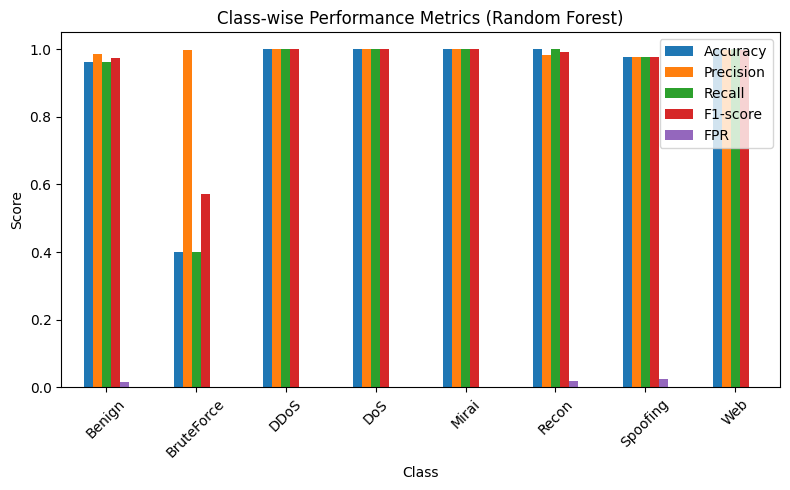

In [ ]:
### RF implemenation ciciot2023
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Use the original feature set without reshaping

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate overall metrics for Random Forest
overall_accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf, recall_rf, f1_score_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')
cm_rf = confusion_matrix(y_test, y_pred_rf)
overall_fpr_rf = np.sum(cm_rf[:, :-1]) / np.sum(cm_rf)

# Print overall metrics for Random Forest
print(f"Overall Accuracy: {overall_accuracy_rf:.4f}")
print(f"Overall Precision: {precision_rf:.4f}")
print(f"Overall Recall: {recall_rf:.4f}")
print(f"Overall F1-score: {f1_score_rf:.4f}")
print(f"Overall FPR: {overall_fpr_rf:.4f}")

# Calculate class-wise metrics for Random Forest
accuracy_per_class_rf = cm_rf.diagonal() / cm_rf.sum(axis=1)
precision_rf_class, recall_rf_class, f1_score_rf_class, _ = precision_recall_fscore_support(y_test, y_pred_rf, average=None)
fpr_rf_class = {}
for i in range(len(encoder.classes_)):
    fpr_rf_class[i] = (cm_rf[:, i].sum() - cm_rf[i, i]) / cm_rf.sum(axis=0)[i]

# Print class-wise metrics for Random Forest
class_names = encoder.classes_
print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'FPR':<10}")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {accuracy_per_class_rf[i]:<10.4f} {precision_rf_class[i]:<10.4f} {recall_rf_class[i]:<10.4f} {f1_score_rf_class[i]:<10.4f} {fpr_rf_class[i]:<10.4f}")

# Plot class-wise metrics for Random Forest
metrics_data_rf = {
    'Class': class_names,
    'Accuracy': accuracy_per_class_rf,
    'Precision': precision_rf_class,
    'Recall': recall_rf_class,
    'F1-score': f1_score_rf_class,
    'FPR': [fpr_rf_class[i] for i in range(len(encoder.classes_))]
}

metrics_df_rf = pd.DataFrame(metrics_data_rf)
metrics_df_rf.plot(kind='bar', x='Class', figsize=(8, 5))
plt.title('Class-wise Performance Metrics (Random Forest)')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_RF.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(plot_directory, 'Class_Wise_Performance_Metrics_RF.jpeg'), format='jpeg', dpi=300)
plt.show()



In [ ]:
## overall  class recall , precision , accuracy , f1-score , FPR 2023
import os
import numpy as np
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# Ensure directory for plots exists
plot_directory = '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the pre-trained model
checkpoint_path = '/content/drive/MyDrive/IDS-Research/BI_GRU_Attention_MD_cic2023July27.h5'
bigru_attention_model = load_model(checkpoint_path)

# Make predictions
y_pred_probs = bigru_attention_model.predict(X_test1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_report = classification_report(Y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(Y_test, y_pred, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Calculate FPR and accuracy for each class
fpr = {}
accuracy_per_class = {}
for i, class_name in enumerate(np.unique(Y_test)):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    fpr[class_name] = fp / (fp + tn) if (fp + tn) != 0 else 0
    accuracy_per_class[class_name] = tp / (tp + fn) if (tp + fn) != 0 else 0

# Add FPR and accuracy to the classification report
for class_name, metrics in class_report.items():
    if class_name.isdigit():  # Only update class-wise metrics
        class_report[class_name]['fpr'] = fpr[int(class_name)]
        class_report[class_name]['accuracy'] = accuracy_per_class[int(class_name)]

# Calculate overall metrics
overall_accuracy = accuracy_score(Y_test, y_pred)
overall_precision, overall_recall, overall_f1_score, _ = precision_recall_fscore_support(Y_test, y_pred, average='weighted')
overall_fpr = np.mean(list(fpr.values()))

# Print the updated classification report
print("Updated Classification Report:")
for class_name, metrics in class_report.items():
    if class_name.isdigit():  # Only print class-wise metrics
        print(f"Class {class_name}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")
        print(f"  FPR: {metrics['fpr']:.4f}")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
    elif class_name in ['macro avg', 'weighted avg']:
        print(f"{class_name.title()}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")
        print(f"  Support: {metrics['support']}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-score: {overall_f1_score:.4f}")
print(f"Overall FPR: {overall_fpr:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/IDS-Research/CIC2013_plots_27/Accuracy_Comparison.svg'

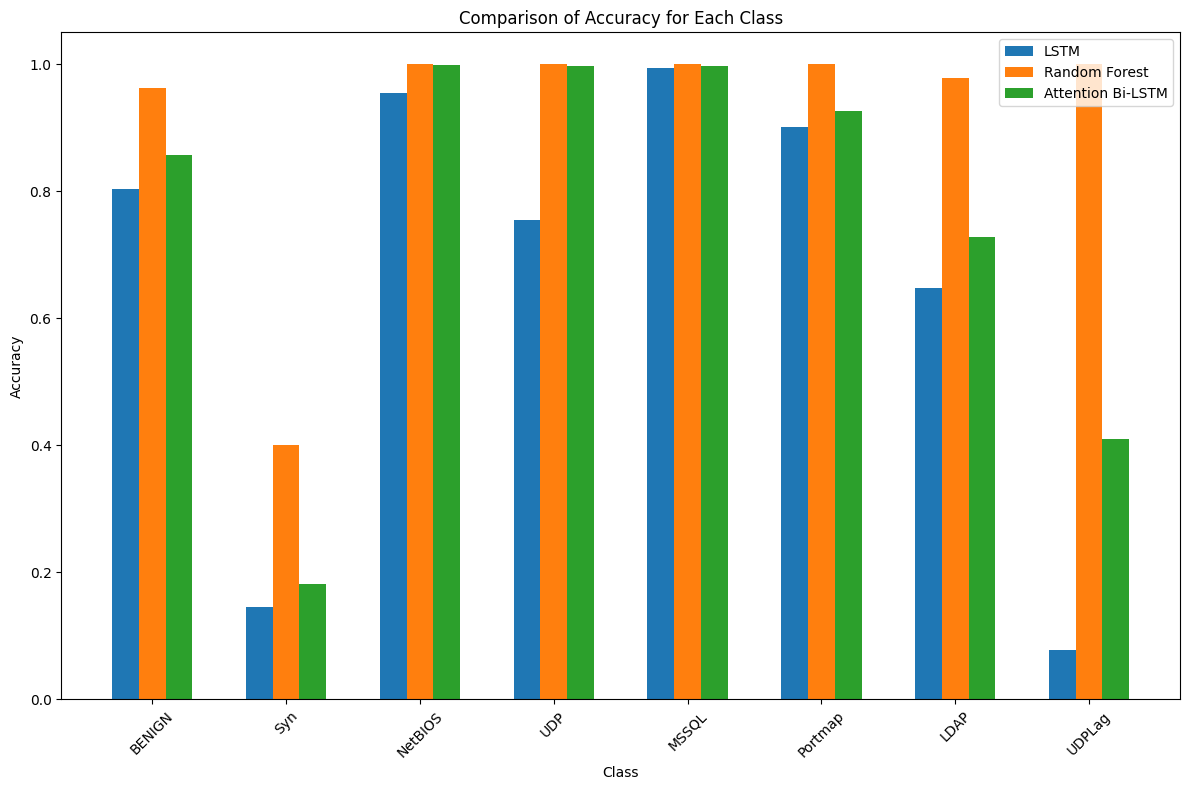

In [ ]:
  # compare the per-class performance of the three algorithms (LSTM, Random Forest, and Attention-based Bi-LSTM),

  import matplotlib.pyplot as plt
  import numpy as np
  import pandas as pd

  # Performance data for each algorithm
  class_names = ['BENIGN', 'Syn', 'NetBIOS', 'UDP', 'MSSQL', 'Portmap', 'LDAP', 'UDPLag']

  # LSTM Performance
  lstm_metrics = {
      'Accuracy': [0.8030, 0.1448, 0.9542, 0.7543, 0.9943, 0.9004, 0.6470, 0.0773],
      'Precision': [0.7633, 0.9898, 0.9217, 0.8507, 0.9991, 0.7536, 0.8669, 0.8612],
      'Recall': [0.8030, 0.1448, 0.9542, 0.7543, 0.9943, 0.9004, 0.6470, 0.0773],
      'F1-score': [0.7827, 0.2527, 0.9377, 0.7996, 0.9967, 0.8205, 0.7410, 0.1419],
      'FPR': [0.2367, 0.0102, 0.0783, 0.1493, 0.0009, 0.2464, 0.1331, 0.1388]
  }

  # Random Forest Performance
  rf_metrics = {
      'Accuracy': [0.9617, 0.4003, 1.0000, 1.0000, 1.0000, 0.9998, 0.9774, 0.9995],
      'Precision': [0.9849, 0.9988, 1.0000, 1.0000, 1.0000, 0.9815, 0.9769, 0.9982],
      'Recall': [0.9617, 0.4003, 1.0000, 1.0000, 1.0000, 0.9998, 0.9774, 0.9995],
      'F1-score': [0.9732, 0.5715, 1.0000, 1.0000, 1.0000, 0.9906, 0.9771, 0.9988],
      'FPR': [0.0151, 0.0012, 0.0000, 0.0000, 0.0000, 0.0185, 0.0231, 0.0018]
  }

  # Attention-based Bi-LSTM Performance
  sa_bilstm_metrics = {
      'Accuracy': [0.8571, 0.1811, 0.9987, 0.9970, 0.9977, 0.9258, 0.7275, 0.4094],
      'Precision': [0.8375, 0.9812, 0.9994, 0.9968, 0.9993, 0.8210, 0.8845, 0.7348],
      'Recall': [0.8571, 0.1811, 0.9987, 0.9970, 0.9977, 0.9258, 0.7275, 0.4094],
      'F1-score': [0.8472, 0.3057, 0.9990, 0.9969, 0.9985, 0.8703, 0.7984, 0.5258],
      'FPR': [0.2231, 0.0002, 0.0019, 0.0013, 0.0003, 0.5904, 0.2789, 0.0901]
  }

  # Plotting function
  def plot_metrics(metric_name):
      fig, ax = plt.subplots(figsize=(12, 8))
      index = np.arange(len(class_names))
      bar_width = 0.2

      bar1 = plt.bar(index, lstm_metrics[metric_name], bar_width, label='LSTM')
      bar2 = plt.bar(index + bar_width, rf_metrics[metric_name], bar_width, label='Random Forest')
      bar3 = plt.bar(index + 2 * bar_width, sa_bilstm_metrics[metric_name], bar_width, label='Attention Bi-LSTM')

      plt.xlabel('Class')
      plt.ylabel(metric_name)
      plt.title(f'Comparison of {metric_name} for Each Class')
      plt.xticks(index + bar_width, class_names, rotation=45)
      plt.legend()

      plt.tight_layout()
      plt.savefig(f'/content/drive/MyDrive/IDS-Research/CIC2013_plots_27/{metric_name}_Comparison.svg', format='svg', dpi=300)
      plt.savefig(f'/content/drive/MyDrive/IDS-Research/CIC2013_plots_27/{metric_name}_Comparison.jpeg', format='jpeg', dpi=300)
      plt.show()

  # Plot each metric
  metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'FPR']
  for metric in metrics:
      plot_metrics(metric)


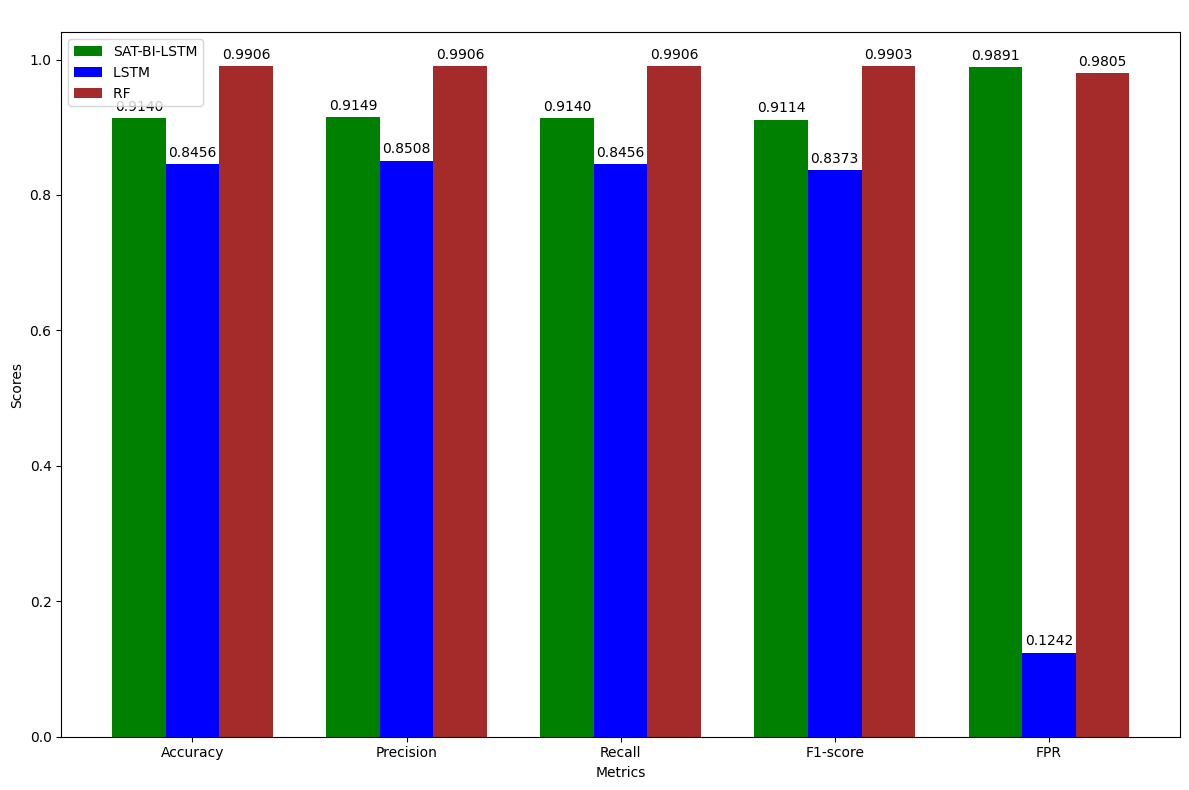

In [ ]:
### comparision RF, LSTM SAT-NI-LSTM
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and their values for each algorithm
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'FPR']
sat_bi_lstm = [0.9140, 0.9149, 0.9140, 0.9114, 0.9891]
lstm_ciciot2023 = [0.8456, 0.8508, 0.8456, 0.8373, 0.1242]
random_forest_2023 = [0.9906, 0.9906, 0.9906, 0.9903, 0.9805]

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))  # Set size to 8x6 inches
bars1 = ax.bar(x - width, sat_bi_lstm, width, label='SAT-BI-LSTM', color='green')  # Deep purple
bars2 = ax.bar(x, lstm_ciciot2023, width, label='LSTM ', color='blue')  # Blue
bars3 = ax.bar(x + width, random_forest_2023, width, label='RF ', color='brown')  # Pink

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title(' ')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of each bar
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

fig.tight_layout()

# Save the plot as SVG and JPEG
plot_directory = '/content/drive/MyDrive/IDS-Research/Comparison_Plots'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

plt.savefig(os.path.join(plot_directory, 'Algorithm_Comparison_Metrics.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(plot_directory, 'Algorithm_Comparison_Metrics.jpeg'), format='jpeg', dpi=300)
plt.show()


In [ ]:
### DNN CICIOT 2023
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the DNN model architecture
dnn_model = Sequential()
dnn_model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
dnn_model_history = dnn_model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test))

# Make predictions
y_pred_probs = dnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
  class_report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)

# Compute and print overall metrics
metrics = classification_report(y_test, y_pred, output_dict=True)
print("Overall Accuracy:", metrics['accuracy'])
print("Overall Precision:", metrics['weighted avg']['precision'])
print("Overall Recall:", metrics['weighted avg']['recall'])
print("Overall F1-score:", metrics['weighted avg']['f1-score'])

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Save the model
dnn_model.save('/content/drive/MyDrive/IDS-Research/CICIoT_DNN_Model_0812.h5')

37303/37303 [==============================] - 52s 1ms/step


TypeError: object of type 'numpy.int64' has no len()

In [ ]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the pre-trained model
dnn_model = load_model('/content/drive/MyDrive/IDS-Research/CICIoT_DNN_Model_0812.h5')

# Load the encoder (if you have saved it or recreate it based on your original code)
# For demonstration purposes, here we assume that encoder is available
# Replace the following line with actual loading of encoder if you have it
# encoder = load_encoder('/path/to/encoder.pkl')  # Adjust path if you have saved the encoder

# Make predictions
y_pred_probs = dnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Use encoder.classes_ if available, or define class names directly
try:
    target_names = encoder.classes_  # Replace with your encoder or class names if available
except NameError:
    # If encoder is not available, use unique class names from y_test
    target_names = [str(i) for i in np.unique(y_test)]

# Classification report
class_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(class_report)

# Compute and print overall metrics
metrics = classification_report(y_test, y_pred, output_dict=True)
print("Overall Accuracy:", metrics['accuracy'])
print("Overall Precision:", metrics['weighted avg']['precision'])
print("Overall Recall:", metrics['weighted avg']['recall'])
print("Overall F1-score:", metrics['weighted avg']['f1-score'])

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(target_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(target_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


37303/37303 [==============================] - 51s 1ms/step


TypeError: object of type 'numpy.int64' has no len()

In [ ]:
###  profiling DNN